# Analysis of Detached Housing Sales in Select Zip Codes Roughly aligned to Western Prince William County, Virginia from 1/1/2000 - 7/13/2021


## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
%pylab inline
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
import scipy.stats as stats

import datetime as dt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RepeatedKFold, cross_val_score

Populating the interactive namespace from numpy and matplotlib


## Import Data

There are four distinct data imports.

The first import will be the 20+ year transaction history of select zip codes. The second import will be an agent's transaction history. The third import will be the geocoded addresses for each transaction.

After a manual process of downloading historical real estate transactions from Bright MLS, the base dataframe has 52,757 sales observations from 1/1/2000 to 7/13/2021.

The historic housing sales data covers housing sales from the following zip codes: 20108, 20109, 20110, 20111, 20112, 20136, 20155, 20156, 20168, 20169, and 20181.

In [2]:
df = pd.read_csv('data/detached_sales.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52758 entries, 0 to 52757
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MLS #                      52758 non-null  object 
 1   Address                    52758 non-null  object 
 2   Zip Code                   52758 non-null  int64  
 3   City                       52758 non-null  object 
 4   DOM                        52758 non-null  object 
 5   Close Date                 52758 non-null  object 
 6   Close Price                52758 non-null  object 
 7   Beds                       52758 non-null  int64  
 8   Bathrooms Full             52758 non-null  int64  
 9   Bathrooms Half             47623 non-null  float64
 10  Subdivision/Neighborhood   52757 non-null  object 
 11  Structure Type             52758 non-null  object 
 12  Basement                   52758 non-null  object 
 13  Fireplaces Total           51530 non-null  flo

In [4]:
df.isnull().sum()

MLS #                            0
Address                          0
Zip Code                         0
City                             0
DOM                              0
Close Date                       0
Close Price                      0
Beds                             0
Bathrooms Full                   0
Bathrooms Half                5135
Subdivision/Neighborhood         1
Structure Type                   0
Basement                         0
Fireplaces Total              1228
Levels/Stories                  65
Total Garage Spaces          12445
Above Grade Finished SQFT    22529
Below Grade Finished SQFT    30870
Condo/Coop Assoc YN              3
Fireplace                     1776
Garage                           0
HOA YN                           0
List Price                       0
Lot Size SqFt                   84
School District              31924
Total Finished SQFT          22464
Year Built                      14
dtype: int64

In [5]:
df.columns

Index(['MLS #', 'Address', 'Zip Code', 'City', 'DOM', 'Close Date',
       'Close Price', 'Beds', 'Bathrooms Full', 'Bathrooms Half',
       'Subdivision/Neighborhood', 'Structure Type', 'Basement',
       'Fireplaces Total', 'Levels/Stories', 'Total Garage Spaces',
       'Above Grade Finished SQFT', 'Below Grade Finished SQFT',
       'Condo/Coop Assoc YN', 'Fireplace', 'Garage', 'HOA YN', 'List Price',
       'Lot Size SqFt', 'School District', 'Total Finished SQFT',
       'Year Built'],
      dtype='object')

In [6]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('/', '_')
df.columns = df.columns.str.lower()

The second import will be a dataset that contains the listing brokerage and listing agent data for all of the MLS transactions

In [7]:
mls_broker_df = pd.read_csv('data/mls_with_broker.csv')

In [8]:
mls_broker_df.head(5)

MLS # List Agent Full Name                List Office Name  \
0  VAPW524270   Kathryn L Gwartney                Homestead Realty   
1  VAPW525438       Kelly Martinez          Coldwell Banker Realty   
2  VAPW524500       Candace B Bush              Redfin Corporation   
3  VAPW524686    Michael J Gillies  RE/MAX Real Estate Connections   
4  VAPW524712        Leslie D Wall       Century 21 Redwood Realty   

  List Office Code  List Office Broker Of Record ID  
0            HOMD1                          98356.0  
1           CBRB58                         113312.0  
2            REFC1                        3017383.0  
3            RAES6                          14410.0  
4          CENT123                          22721.0

In [9]:
mls_broker_df.columns = mls_broker_df.columns.str.lower().str.replace(' ','_', regex=False).str.strip()

In [10]:
mls_broker_df.head(5)

mls_# list_agent_full_name                list_office_name  \
0  VAPW524270   Kathryn L Gwartney                Homestead Realty   
1  VAPW525438       Kelly Martinez          Coldwell Banker Realty   
2  VAPW524500       Candace B Bush              Redfin Corporation   
3  VAPW524686    Michael J Gillies  RE/MAX Real Estate Connections   
4  VAPW524712        Leslie D Wall       Century 21 Redwood Realty   

  list_office_code  list_office_broker_of_record_id  
0            HOMD1                          98356.0  
1           CBRB58                         113312.0  
2            REFC1                        3017383.0  
3            RAES6                          14410.0  
4          CENT123                          22721.0

In [11]:
mls_broker_df.columns

Index(['mls_#', 'list_agent_full_name', 'list_office_name', 'list_office_code',
       'list_office_broker_of_record_id'],
      dtype='object')

In [12]:
pd.merge(df, mls_broker_df, on='mls_#', how='inner')

mls_#                  address  zip_code         city  dom  \
0      VAPW289124   10087 Post Oak Terrace     20110     Manassas   12   
1      VAPW250326       7409 Howell Run Ct     20112     Manassas    1   
2      VAPW284200      8543 Dover Downs Ct     20155  Gainesville    5   
3      VAPW289210      10415 Labrador Loop     20112     Manassas    3   
4      VAPW292248  7544 Belle Grae Dr #1-5     20109     Manassas  456   
...           ...                      ...       ...          ...  ...   
52751  VAPW521352   13130 Carriage Ford Rd     20181   Nokesville    5   
52752  VAPW524372       10209 Inchberry Ct     20136      Bristow    6   
52753  VAPW514438      9128 Acadia Park Dr     20136      Bristow    4   
52754  VAMN141788        9173 Firethorn Ct     20110     Manassas    6   
52755  VAPW522940       9614 Lafayette Ave     20109     Manassas    7   

      close_date   close_price  beds  bathrooms_full  bathrooms_half  ...  \
0         1/3/00  $304,417.00      4               2             1.0  ...   
1         1/4/00  $311,528.00      4               3             1.0  ...   
2         1/6/00  $219,500.00      3               2             1.0  ...   
3         1/6/00  $199,950.00      4               2             1.0  ...   
4         1/6/00   $56,000.00      3               2             NaN  ...   
...          ...           ...   ...             ...             ...  ...   
52751    6/28/21  $895,000.00      4               4             1.0  ...   
52752     7/7/21  $685,000.00      4               2             1.0  ...   
52753    6/30/21  $820,000.00      4               4             1.0  ...   
52754    6/28/21  $439,000.00      5               3             NaN  ...   
52755    6/30/21  $349,000.00      4               2             NaN  ...   

      hoa_yn    list_price lot_size_sqft  \
0         No  $271,000.00        16453.0   
1         No  $311,528.00        20364.0   
2         No  $219,500.00        13425.0   
3         No  $199,950.00         7980.0   
4         No   $56,000.00            0.0   
...      ...           ...           ...   
52751    Yes  $895,000.00       350135.0   
52752    Yes  $634,500.00        10062.0   
52753    Yes  $809,900.00        11757.0   
52754     No  $439,000.00        10197.0   
52755     No  $349,000.00        10010.0   

                            school_district total_finished_sqft  year_built  \
0      Prince William County Public Schools               3,134      1999.0   
1                                       NaN                 NaN      1999.0   
2      Prince William County Public Schools               2,130      1997.0   
3                                       NaN                 NaN      1991.0   
4                                       NaN                 NaN      1986.0   
...                                     ...                 ...         ...   
52751  Prince William County Public Schools               3,812      1991.0   
52752  Prince William County Public Schools               3,587      2005.0   
52753  Prince William County Public Schools               6,240      2003.0   
52754          Manassas City Public Schools               1,138      1976.0   
52755  Prince William County Public Schools               1,310      1965.0   

             list_agent_full_name                   list_office_name  \
0                     John A Dunn            Dunn & Associates, Inc.   
1                      Non Member                              Comps   
2                 Susan M Buckley               Century 21 Champions   
3                Shirley R Beyerl  Coldwell Banker Stevens, REALTORS   
4                      Non Member                              Comps   
...                           ...                                ...   
52751                  Tony O Saa                 Weichert, REALTORS   
52752                 Soyup H Cho                 Weichert, REALTORS   
52753  Patricia (Pat) A Hackerson                 Weichert, REALTORS   


In [13]:
df = pd.merge(df, mls_broker_df, on='mls_#', how='inner')

In [14]:
df.sample(5)

mls_#                   address  zip_code           city dom  \
17928  VAPW133610  10057 Pentland Hills Way     20136        Bristow  84   
16123  VAMP103350             247 Cabbel Dr     20111  Manassas Park  62   
23288  1005139254            200 Lambert Dr     20111  Manassas Park  15   
5258   VAMP103442            200 Lambert Dr     20111  Manassas Park  15   
39891  1000319595            7801 Tayloe Dr     20112       Manassas  15   

      close_date   close_price  beds  bathrooms_full  bathrooms_half  ...  \
17928   12/18/06  $389,000.00      3               3             1.0  ...   
16123    2/24/06  $309,990.00      3               1             NaN  ...   
23288    3/20/09  $105,000.00      3               1             0.0  ...   
5258     8/29/02  $162,900.00      3               1             1.0  ...   
39891    8/18/16  $330,000.00      4               3             0.0  ...   

      hoa_yn    list_price lot_size_sqft  \
17928    Yes  $399,900.00         3537.0   
16123     No  $309,990.00         1307.0   
23288     No  $105,000.00         7700.0   
5258      No  $162,900.00         7700.0   
39891     No  $330,000.00        25003.0   

                            school_district total_finished_sqft  year_built  \
17928  Prince William County Public Schools                 NaN      2004.0   
16123     Manassas Park City Public Schools               1,008      1955.0   
23288                                   NaN               1,075      1959.0   
5258      Manassas Park City Public Schools                 NaN      1959.0   
39891  Prince William County Public Schools                 NaN      1976.0   

      list_agent_full_name                 list_office_name list_office_code  \
17928        Karen E Close  Long & Foster Real Estate, Inc.            LNG83   
16123      Claudia H Ortiz         The Pride of Real Estate            TPRL1   
23288         Nora L Mundy        Century 21 Redwood Realty           CENT12   
5258           Mary J King            RE/MAX Olympic Realty           RMAX22   
39891     Kathleen Vetrano                   RE/MAX Gateway          RMAX153   

      list_office_broker_of_record_id  
17928                         18809.0  
16123                             NaN  
23288                         22721.0  
5258                              NaN  
39891                         44294.0  

[5 rows x 31 columns]

The third import is a dataset that contains the transaction history for a specific agent for inclusion in analysis later on in the project

In [15]:
agent_transactions_df = pd.read_csv('data/agent_transactions.csv')

In [16]:
agent_transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mls_num                     74 non-null     object 
 1   use                         74 non-null     int64  
 2   type                        74 non-null     object 
 3   type_description            74 non-null     object 
 4   street_address              74 non-null     object 
 5   city                        74 non-null     object 
 6   list_price                  74 non-null     int64  
 7   sold_price                  74 non-null     int64  
 8   list_date                   74 non-null     object 
 9   sold_date                   74 non-null     object 
 10  days_on_market              74 non-null     int64  
 11  list_to_close_days          74 non-null     int64  
 12  ratification_to_close_days  74 non-null     int64  
 13  list_year                   74 non-nu

Agent transactions Data Cleaning

Data cleaning will first concentrate on cleaning the agent_transaction_df dataframe before moving onto the primary dataframe, df, which contains the 20+ years of house sales.

In [17]:
agent_transactions_df.head()

mls_num  use              type type_description      street_address  \
0  1000295275    1  listed_coop_sold             sell     8935 Sweetbriar   
1  1000321115    0  coop_listed_sold              buy        4205 Roeburn   
2  1000341439    0  coop_listed_sold              buy     6914 Bitterroot   
3  1000355417    0  coop_listed_sold              buy  8214 Winstead #102   
4  1001324077    0  coop_listed_sold              buy           755 Aylor   

            city  list_price  sold_price list_date sold_date  days_on_market  \
0       Manassas      337500      337500   3/25/16   4/29/16               5   
1     Woodbridge      974990      936500    7/6/16  12/30/16             117   
2    Gainesville      465000      475000   9/21/16  10/28/16               4   
3       Manassas      199000      190000  11/16/16  12/28/16              12   
4  Stephens City      220000      213000    6/8/15    5/4/16             250   

   list_to_close_days  ratification_to_close_days  list_year  sold_year  \
0                  36                          31       2016       2016   
1                 178                          61       2016       2016   
2                  38                          34       2016       2016   
3                  43                          31       2016       2016   
4                 332                          82       2015       2016   

   Unnamed: 15 Unnamed: 16  
0          NaN  1000295275  
1          NaN         NaN  
2          NaN  1000341439  
3          NaN         NaN  
4          NaN         NaN

In [18]:
agent_buy_sell_dual_df = agent_transactions_df.loc[
                         (agent_transactions_df.type_description == 'sell')|
                         (agent_transactions_df.type_description == 'buy')|
                         (agent_transactions_df.type_description == 'dual'), :].reset_index()

In [19]:
agent_buy_sell_dual_df

index      mls_num  use              type type_description  \
0       0   1000295275    1  listed_coop_sold             sell   
1       1   1000321115    0  coop_listed_sold              buy   
2       2   1000341439    0  coop_listed_sold              buy   
3       3   1000355417    0  coop_listed_sold              buy   
4       4   1001324077    0  coop_listed_sold              buy   
..    ...          ...  ...               ...              ...   
61     69   VAMN141456    1  listed_coop_sold             sell   
62     70   VAMN141736    1  listed_coop_sold             sell   
63     71   VAPW516932    0  coop_listed_sold              buy   
64     72   VAMN142132    1  listed_coop_sold             sell   
65     73  VAFX2004794    0  coop_listed_sold              buy   

         street_address           city  list_price  sold_price list_date  \
0       8935 Sweetbriar       Manassas      337500      337500   3/25/16   
1          4205 Roeburn     Woodbridge      974990      936500    7/6/16   
2       6914 Bitterroot    Gainesville      465000      475000   9/21/16   
3    8214 Winstead #102       Manassas      199000      190000  11/16/16   
4             755 Aylor  Stephens City      220000      213000    6/8/15   
..                  ...            ...         ...         ...       ...   
61       8886 Quarry Rd       Manassas      424999      438000   3/26/21   
62   8924 Longstreet Dr       Manassas      599999      629000   4/29/21   
63   11951 Bluegrass Ct     Nokesville      699999      725000   3/24/21   
64  8683 Point of Woods       Manassas      359000      373000   6/10/21   
65         4300 Valiant      Annandale      700000      700000    7/1/21   

   sold_date  days_on_market  list_to_close_days  ratification_to_close_days  \
0    4/29/16               5                  36                          31   
1   12/30/16             117                 178                          61   
2   10/28/16               4                  38                          34   
3   12/28/16              12                  43                          31   
4     5/4/16             250                 332                          82   
..       ...             ...                 ...                         ...   
61   5/17/21               6                  53                          47   
62    6/1/21               0                  34                          34   
63   4/30/21               4                  38                          34   
64    7/9/21               5                  30                          25   
65   6/29/21               0                  -1                          -1   

    list_year  sold_year  Unnamed: 15 Unnamed: 16  
0        2016       2016          NaN  1000295275  
1        2016       2016          NaN         NaN  
2        2016       2016          NaN  1000341439  
3        2016       2016          NaN         NaN  
4        2015       2016          NaN         NaN  
..        ...        ...          ...         ...  
61       2021       2021          NaN         NaN  
62       2021       2021          NaN  VAMN141736  
63       2021       2021          NaN  VAPW516932  
64       2021       2021          NaN         NaN  
65       2021       2021          NaN         NaN  

[66 rows x 18 columns]

In [20]:
agent_buy_sell_dual_mls_num = list(agent_buy_sell_dual_df.mls_num)

In [21]:
agent_buy_sell_dual_mls_num

['1000295275',
 '1000321115',
 '1000341439',
 '1000355417',
 '1001324077',
 '1002604652',
 '1002614678',
 '1000172637',
 '1000368267',
 '1000368739',
 '1000381843',
 '1000385543',
 '1000389835',
 '1000390055',
 '1000390671',
 '1000983977',
 '1001639763',
 '1001640931',
 '1001788297',
 '1004121557',
 '1000379225',
 '1002121356',
 'VAPW100302',
 '1000361786',
 '1000426604',
 '1000426798',
 '1000450686',
 '1001184340',
 '1001950134',
 '1002346450',
 '1003289680',
 'VAMN100010',
 '1000363376',
 '1002013606',
 '1002149434',
 '1004472545',
 '1005468057',
 '1005958667',
 '1007546104',
 '1002345500',
 'VAMN100013',
 'VAMN138342',
 'VAPW432086',
 'VAPW474548',
 'VAPW475184',
 'VAPW480200',
 'VAMN138052',
 'VAFQ165798',
 'VAMP114154',
 'VAPW472988',
 'VAPW487094',
 'VAPW487732',
 'VAPW498766',
 'VAFX1149450',
 'VAMN139398',
 'VAPW496830',
 'VAPW520948',
 'VALO428754',
 'VAPW515698',
 'VAPW517998',
 'VAMN141710',
 'VAMN141456',
 'VAMN141736',
 'VAPW516932',
 'VAMN142132',
 'VAFX2004794']

For analysis, create datframes that capture all of the agent's sales and all of the agent's buys.  Listings where the agent was an alternate agent will not be used. Listings where the agent was acting as a dual agent will be used.

In [22]:
agent_sales_df = agent_transactions_df.loc[
                 (agent_transactions_df.type_description == 'sell') |
                 (agent_transactions_df.type_description == 'dual'), :].reset_index()

In [23]:
agent_sales_df.head(5)

index     mls_num  use              type type_description  \
0      0  1000295275    1  listed_coop_sold             sell   
1     15  1000172637    1  listed_coop_sold             sell   
2     16  1000368267    1  listed_coop_sold             sell   
3     17  1000368739    1  listed_coop_sold             sell   
4     18  1000381843    1  listed_coop_sold             sell   

       street_address         city  list_price  sold_price list_date  \
0     8935 Sweetbriar     Manassas      337500      337500   3/25/16   
1      8420 Tackhouse  Gainesville      349000      349000   7/26/17   
2  7595 Gales #4B-101     Manassas      119900      110000    2/8/17   
3    9283 Sumner Lake     Manassas      549900      553000   2/15/17   
4  9000 Sandalwood #D     Manassas      195000      182000    4/5/17   

  sold_date  days_on_market  list_to_close_days  ratification_to_close_days  \
0   4/29/16               5                  36                          31   
1   9/29/17               7                  66                          59   
2   3/23/17              19                  44                          25   
3   5/12/17              12                  87                          75   
4   8/18/17              96                 136                          40   

   list_year  sold_year  Unnamed: 15 Unnamed: 16  
0       2016       2016          NaN  1000295275  
1       2017       2017          NaN         NaN  
2       2017       2017          NaN         NaN  
3       2017       2017          NaN  1000368739  
4       2017       2017          NaN         NaN

In [24]:
agent_sales_mls_num = list(agent_sales_df.mls_num)

In [25]:
agent_buys_df = agent_transactions_df.loc[
                (agent_transactions_df.type_description == 'buy') |
                (agent_transactions_df.type_description == 'dual'), :].reset_index()

In [26]:
agent_buys_df.head(5)

index     mls_num  use              type type_description  \
0      1  1000321115    0  coop_listed_sold              buy   
1      2  1000341439    0  coop_listed_sold              buy   
2      3  1000355417    0  coop_listed_sold              buy   
3      4  1001324077    0  coop_listed_sold              buy   
4      5  1002604652    0  coop_listed_sold              buy   

       street_address           city  list_price  sold_price list_date  \
0        4205 Roeburn     Woodbridge      974990      936500    7/6/16   
1     6914 Bitterroot    Gainesville      465000      475000   9/21/16   
2  8214 Winstead #102       Manassas      199000      190000  11/16/16   
3           755 Aylor  Stephens City      220000      213000    6/8/15   
4       River Mill Rd  Richardsville       58999       55000    5/7/15   

  sold_date  days_on_market  list_to_close_days  ratification_to_close_days  \
0  12/30/16             117                 178                          61   
1  10/28/16               4                  38                          34   
2  12/28/16              12                  43                          31   
3    5/4/16             250                 332                          82   
4   4/20/16             313                 350                          37   

   list_year  sold_year  Unnamed: 15 Unnamed: 16  
0       2016       2016          NaN         NaN  
1       2016       2016          NaN  1000341439  
2       2016       2016          NaN         NaN  
3       2015       2016          NaN         NaN  
4       2015       2016          NaN         NaN

In [27]:
agent_buys_mls_num = list(agent_buys_df.mls_num)

The fourth dataset import is a dataframe that contains the full address and accompanying latitude and longitude for address. This geocoded dataset was geocoded using the service at geocodio. After some dataframe cleaning, the geocoded dataframe will be merged with the main transaction dataframe.


In [28]:
geocode_df = pd.read_csv('data/transactions_full_address_geocodio.csv', index_col=[0])

In [29]:
geocode_df.columns = geocode_df.columns.str.lower().str.replace(' ','_', regex=False)

In [30]:
geocode_df = geocode_df[['mls_#',
                         'latitude',
                         'longitude']]

Upon review of the latitude and longitude data, Geocodio consistenly mis-coded the longitude for the address. After a manual review of 30 transactions, the longitude was off by an average 0.0023. Because of this, I will manually add 0.0022 to the longitude series as a crude correction. The latitude was off by an average of 0.0000043. The difference between the geocodio latitude and the correct google search latitude showed greater variance than the longitude. The latitude difference was both a positive and negative difference.

In [31]:
long_correction = 0.0023
lat_correction = 0.0000043

In [32]:
geocode_df['longitude'] = geocode_df.longitude - long_correction
geocode_df['latitude'] = geocode_df.latitude - lat_correction

In [33]:
geocode_df

mls_#   latitude  longitude
0      VAPW289124  38.729589 -77.502239
1      VAPW250326  38.672901 -77.428282
2      VAPW284200  38.771562 -77.602819
3      VAPW289210  38.728245 -77.480414
4      VAPW292248  38.792258 -77.511938
...           ...        ...        ...
52753  VAPW521352  38.672182 -77.587255
52754  VAPW524372  38.734527 -77.585500
52755  VAPW514438  38.757925 -77.571293
52756  VAMN141788  38.771649 -77.475272
52757  VAPW522940  38.787573 -77.488299

[52758 rows x 3 columns]

### Add columns to main dataframe, df, to capture agent_transaction_df derivative dataframe information

Add column to flag an observation as whether it belongs to the agent as a sale or dual agency.

In [34]:
df.loc[df['mls_#'].isin(agent_sales_mls_num), :]

mls_#                address  zip_code         city  dom  \
38923  1000295275     8935 Sweetbriar St     20110     Manassas    5   
41538  1000368739  9283 Sumner Lake Blvd     20110     Manassas   12   
43097  1000983977          6773 River Rd     20111     Manassas   46   
44222  1000361786       1610 Mountain Rd     20169    Haymarket   11   
44504  1000426604     6914 Bitterroot Ct     20155  Gainesville   29   
44639  1001950134      8309 Tillett Loop     20110     Manassas   17   
45587  1002346450    11913 Smithfield Rd     20112     Manassas   53   
46649  VAPW432086       7787 Fern Oak Ct     20112     Manassas   54   
47495  VAPW474548    10459 Labrador Loop     20112     Manassas    2   
47870  VAPW480200    4107 Mount Atlas Ln     20169    Haymarket    4   
48534  VAPW472988        5712 Yewing Way     20155  Gainesville  203   
48747  VAPW487732   9625 Laurencekirk Pl     20136      Bristow    7   
48970  VAPW487094     12335 Sherborne St     20136      Bristow    3   
51932  VAPW517998  13198 Kirkmichael Ter     20136      Bristow    3   
52307  VAMN141736     8924 Longstreet Dr     20110     Manassas    0   

      close_date   close_price  beds  bathrooms_full  bathrooms_half  ...  \
38923    4/29/16  $337,500.00      3               2             1.0  ...   
41538    5/12/17  $553,000.00      4               3             1.0  ...   
43097   11/22/17  $440,000.00      3               3             0.0  ...   
44222    5/30/18  $375,000.00      4               2             1.0  ...   
44504    6/27/18  $495,000.00      4               2             1.0  ...   
44639    7/12/18  $441,000.00      4               2             1.0  ...   
45587   11/30/18  $340,000.00      3               3             0.0  ...   
46649    5/30/19  $415,000.00      3               3             1.0  ...   
47495    8/29/19  $445,000.00      5               2             1.0  ...   
47870   10/21/19  $400,000.00      3               2             1.0  ...   
48534    2/25/20  $899,999.00      5               4             1.0  ...   
48747    3/27/20  $522,000.00      4               3             1.0  ...   
48970    4/28/20  $527,000.00      4               3             4.0  ...   
51932    4/30/21  $625,000.00      4               4             1.0  ...   
52307     6/1/21  $629,999.00      4               3             1.0  ...   

      hoa_yn    list_price lot_size_sqft  \
38923     No  $337,500.00        10956.0   
41538    Yes  $549,900.00        18422.0   
43097     No  $449,000.00        43560.0   
44222     No  $374,999.00        46888.0   
44504    Yes  $489,999.00         6294.0   
44639    Yes  $441,000.00         5821.0   
45587     No  $364,999.00        35000.0   
46649     No  $414,900.00        53222.0   
47495    Yes  $439,999.00         8268.0   
47870     No  $395,000.00        45969.0   
48534    Yes  $899,999.00        47311.0   
48747    Yes  $524,999.00         8115.0   
48970    Yes  $524,999.00        10607.0   
51932    Yes  $574,999.00         9679.0   
52307     No  $599,999.00        20000.0   

                            school_district total_finished_sqft  year_built  \
38923          Manassas City Public Schools               1,500      1978.0   
41538          Manassas City Public Schools               5,241      2003.0   
43097  Prince William County Public Schools               2,501      1984.0   
44222  Prince William County Public Schools               2,600      1980.0   
44504  Prince William County Public Schools               3,634      2005.0   
44639          Manassas City Public Schools               2,690      2003.0   
45587  Prince William County Public Schools               1,779      1972.0   
46649  Prince William County Public Schools               2,794      1981.0   
47495  Prince William County Public Schools               2,740      1989.0   
47870  Prince William County Public Schools               1,668      1996.0   
48534  Prince William County Public Schools         

In [35]:
df['mls_#'].isin(agent_sales_mls_num)

0        False
1        False
2        False
3        False
4        False
         ...  
52751    False
52752    False
52753    False
52754    False
52755    False
Name: mls_#, Length: 52756, dtype: bool

In [36]:
df['agent_sale_dual'] = df['mls_#'].isin(agent_sales_mls_num)

In [37]:
df.head()

mls_#                  address  zip_code         city  dom close_date  \
0  VAPW289124   10087 Post Oak Terrace     20110     Manassas   12     1/3/00   
1  VAPW250326       7409 Howell Run Ct     20112     Manassas    1     1/4/00   
2  VAPW284200      8543 Dover Downs Ct     20155  Gainesville    5     1/6/00   
3  VAPW289210      10415 Labrador Loop     20112     Manassas    3     1/6/00   
4  VAPW292248  7544 Belle Grae Dr #1-5     20109     Manassas  456     1/6/00   

    close_price  beds  bathrooms_full  bathrooms_half  ...    list_price  \
0  $304,417.00      4               2             1.0  ...  $271,000.00    
1  $311,528.00      4               3             1.0  ...  $311,528.00    
2  $219,500.00      3               2             1.0  ...  $219,500.00    
3  $199,950.00      4               2             1.0  ...  $199,950.00    
4   $56,000.00      3               2             NaN  ...   $56,000.00    

  lot_size_sqft                       school_district  total_finished_sqft  \
0       16453.0  Prince William County Public Schools                3,134   
1       20364.0                                   NaN                  NaN   
2       13425.0  Prince William County Public Schools                2,130   
3        7980.0                                   NaN                  NaN   
4           0.0                                   NaN                  NaN   

  year_built  list_agent_full_name                   list_office_name  \
0     1999.0           John A Dunn            Dunn & Associates, Inc.   
1     1999.0            Non Member                              Comps   
2     1997.0       Susan M Buckley               Century 21 Champions   
3     1991.0      Shirley R Beyerl  Coldwell Banker Stevens, REALTORS   
4     1986.0            Non Member                              Comps   

  list_office_code list_office_broker_of_record_id agent_sale_dual  
0            DUNN1                             NaN           False  
1            COMP1                             NaN           False  
2           CENT70                             NaN           False  
3            CBS20                             NaN           False  
4            COMP1                             NaN           False  

[5 rows x 32 columns]

In [38]:
agent_sale_dual_map = {'Yes': 1,
                       'No': 0}

df['agent_sale_dual'] = df.agent_sale_dual.replace(agent_sale_dual_map).astype('int')

In [39]:
df.head()

mls_#                  address  zip_code         city  dom close_date  \
0  VAPW289124   10087 Post Oak Terrace     20110     Manassas   12     1/3/00   
1  VAPW250326       7409 Howell Run Ct     20112     Manassas    1     1/4/00   
2  VAPW284200      8543 Dover Downs Ct     20155  Gainesville    5     1/6/00   
3  VAPW289210      10415 Labrador Loop     20112     Manassas    3     1/6/00   
4  VAPW292248  7544 Belle Grae Dr #1-5     20109     Manassas  456     1/6/00   

    close_price  beds  bathrooms_full  bathrooms_half  ...    list_price  \
0  $304,417.00      4               2             1.0  ...  $271,000.00    
1  $311,528.00      4               3             1.0  ...  $311,528.00    
2  $219,500.00      3               2             1.0  ...  $219,500.00    
3  $199,950.00      4               2             1.0  ...  $199,950.00    
4   $56,000.00      3               2             NaN  ...   $56,000.00    

  lot_size_sqft                       school_district  total_finished_sqft  \
0       16453.0  Prince William County Public Schools                3,134   
1       20364.0                                   NaN                  NaN   
2       13425.0  Prince William County Public Schools                2,130   
3        7980.0                                   NaN                  NaN   
4           0.0                                   NaN                  NaN   

  year_built  list_agent_full_name                   list_office_name  \
0     1999.0           John A Dunn            Dunn & Associates, Inc.   
1     1999.0            Non Member                              Comps   
2     1997.0       Susan M Buckley               Century 21 Champions   
3     1991.0      Shirley R Beyerl  Coldwell Banker Stevens, REALTORS   
4     1986.0            Non Member                              Comps   

  list_office_code list_office_broker_of_record_id agent_sale_dual  
0            DUNN1                             NaN               0  
1            COMP1                             NaN               0  
2           CENT70                             NaN               0  
3            CBS20                             NaN               0  
4            COMP1                             NaN               0  

[5 rows x 32 columns]

Merge the geocode_df to df so the df will now contain all latitude and longitude values for each transaction

In [40]:
pd.merge(df, geocode_df, on='mls_#', how='outer').head(5)

mls_#                  address  zip_code         city  dom close_date  \
0  VAPW289124   10087 Post Oak Terrace   20110.0     Manassas   12     1/3/00   
1  VAPW250326       7409 Howell Run Ct   20112.0     Manassas    1     1/4/00   
2  VAPW284200      8543 Dover Downs Ct   20155.0  Gainesville    5     1/6/00   
3  VAPW289210      10415 Labrador Loop   20112.0     Manassas    3     1/6/00   
4  VAPW292248  7544 Belle Grae Dr #1-5   20109.0     Manassas  456     1/6/00   

    close_price  beds  bathrooms_full  bathrooms_half  ...  \
0  $304,417.00    4.0             2.0             1.0  ...   
1  $311,528.00    4.0             3.0             1.0  ...   
2  $219,500.00    3.0             2.0             1.0  ...   
3  $199,950.00    4.0             2.0             1.0  ...   
4   $56,000.00    3.0             2.0             NaN  ...   

                        school_district total_finished_sqft year_built  \
0  Prince William County Public Schools               3,134     1999.0   
1                                   NaN                 NaN     1999.0   
2  Prince William County Public Schools               2,130     1997.0   
3                                   NaN                 NaN     1991.0   
4                                   NaN                 NaN     1986.0   

   list_agent_full_name                   list_office_name  list_office_code  \
0           John A Dunn            Dunn & Associates, Inc.             DUNN1   
1            Non Member                              Comps             COMP1   
2       Susan M Buckley               Century 21 Champions            CENT70   
3      Shirley R Beyerl  Coldwell Banker Stevens, REALTORS             CBS20   
4            Non Member                              Comps             COMP1   

  list_office_broker_of_record_id agent_sale_dual   latitude  longitude  
0                             NaN             0.0  38.729589 -77.502239  
1                             NaN             0.0  38.672901 -77.428282  
2                             NaN             0.0  38.771562 -77.602819  
3                             NaN             0.0  38.728245 -77.480414  
4                             NaN             0.0  38.792258 -77.511938  

[5 rows x 34 columns]

In [41]:
df = pd.merge(df, geocode_df, on='mls_#', how='outer')

In [42]:
print(df.columns)
df.head(5)

Index(['mls_#', 'address', 'zip_code', 'city', 'dom', 'close_date',
       'close_price', 'beds', 'bathrooms_full', 'bathrooms_half',
       'subdivision_neighborhood', 'structure_type', 'basement',
       'fireplaces_total', 'levels_stories', 'total_garage_spaces',
       'above_grade_finished_sqft', 'below_grade_finished_sqft',
       'condo_coop_assoc_yn', 'fireplace', 'garage', 'hoa_yn', 'list_price',
       'lot_size_sqft', 'school_district', 'total_finished_sqft', 'year_built',
       'list_agent_full_name', 'list_office_name', 'list_office_code',
       'list_office_broker_of_record_id', 'agent_sale_dual', 'latitude',
       'longitude'],
      dtype='object')


mls_#                  address  zip_code         city  dom close_date  \
0  VAPW289124   10087 Post Oak Terrace   20110.0     Manassas   12     1/3/00   
1  VAPW250326       7409 Howell Run Ct   20112.0     Manassas    1     1/4/00   
2  VAPW284200      8543 Dover Downs Ct   20155.0  Gainesville    5     1/6/00   
3  VAPW289210      10415 Labrador Loop   20112.0     Manassas    3     1/6/00   
4  VAPW292248  7544 Belle Grae Dr #1-5   20109.0     Manassas  456     1/6/00   

    close_price  beds  bathrooms_full  bathrooms_half  ...  \
0  $304,417.00    4.0             2.0             1.0  ...   
1  $311,528.00    4.0             3.0             1.0  ...   
2  $219,500.00    3.0             2.0             1.0  ...   
3  $199,950.00    4.0             2.0             1.0  ...   
4   $56,000.00    3.0             2.0             NaN  ...   

                        school_district total_finished_sqft year_built  \
0  Prince William County Public Schools               3,134     1999.0   
1                                   NaN                 NaN     1999.0   
2  Prince William County Public Schools               2,130     1997.0   
3                                   NaN                 NaN     1991.0   
4                                   NaN                 NaN     1986.0   

   list_agent_full_name                   list_office_name  list_office_code  \
0           John A Dunn            Dunn & Associates, Inc.             DUNN1   
1            Non Member                              Comps             COMP1   
2       Susan M Buckley               Century 21 Champions            CENT70   
3      Shirley R Beyerl  Coldwell Banker Stevens, REALTORS             CBS20   
4            Non Member                              Comps             COMP1   

  list_office_broker_of_record_id agent_sale_dual   latitude  longitude  
0                             NaN             0.0  38.729589 -77.502239  
1                             NaN             0.0  38.672901 -77.428282  
2                             NaN             0.0  38.771562 -77.602819  
3                             NaN             0.0  38.728245 -77.480414  
4                             NaN             0.0  38.792258 -77.511938  

[5 rows x 34 columns]

In [43]:
df.dtypes

mls_#                               object
address                             object
zip_code                           float64
city                                object
dom                                 object
close_date                          object
close_price                         object
beds                               float64
bathrooms_full                     float64
bathrooms_half                     float64
subdivision_neighborhood            object
structure_type                      object
basement                            object
fireplaces_total                   float64
levels_stories                      object
total_garage_spaces                float64
above_grade_finished_sqft           object
below_grade_finished_sqft           object
condo_coop_assoc_yn                 object
fireplace                           object
garage                              object
hoa_yn                              object
list_price                          object
lot_size_sq

### close_date

In [44]:
df['close_date'] = pd.to_datetime(df.close_date)
df['close_month'] = pd.DatetimeIndex(df.close_date).month
df['close_year'] = pd.DatetimeIndex(df.close_date).year

In [45]:
print(f'The minimum date in the dataframe is:\n{np.min(df.close_date)}\n')
print(f'The maximum date in the dataframe is:\n{np.max(df.close_date)}')

The minimum date in the dataframe is:
2000-01-03 00:00:00

The maximum date in the dataframe is:
2021-07-13 00:00:00


### close_price

In [46]:
df.close_price.isnull().sum()

2

In [47]:
df = df.loc[df.close_price.notnull(), :]

In [48]:
df['close_price'] = df.close_price.str.replace('$', '', regex=False)
df['close_price'] = df.close_price.str.replace(',', '')
df['close_price'] = df.close_price.str.split('.', 1, expand=True)[0].astype(int)

Check for odd closing prices at the low end

In [49]:
df.loc[df.close_price <= 10_000, :]

mls_#          address  zip_code         city  dom close_date  \
41     VAPW273384  14456 Sedona Dr   20155.0  Gainesville  137 2000-01-25   
45684  1002244130   13550 Frost Dr   20181.0   Nokesville   46 2018-12-17   

       close_price  beds  bathrooms_full  bathrooms_half  ... year_built  \
41            2200   5.0             3.0             1.0  ...     1997.0   
45684         4310   5.0             3.0             1.0  ...     1985.0   

      list_agent_full_name                 list_office_name  list_office_code  \
41      Thomas S Granberry  Long & Foster Real Estate, Inc.             LNG89   
45684  Cinthia K Thornhill        Century 21 New Millennium            CENM21   

      list_office_broker_of_record_id  agent_sale_dual   latitude  longitude  \
41                                NaN              0.0  38.788692 -77.623175   
45684                        130778.0              0.0  38.661298 -77.463282   

      close_month close_year  
41            1.0     2000.0  
45684        12.0     2018.0  

[2 rows x 36 columns]

MLS # VAPW273384 looks as if the agent did not input the correct closing price, so the close_price will be changed to $322,000 from 2200.

MLS # 1002244130 looks as if the agent did not add the trailing two 0s to the sale documentation, so the close_price will be changed to $431,000


In [50]:
df.loc[df['mls_#'] == 'VAPW273384', 'close_price'] = 322000

In [51]:
df.loc[df['mls_#'] == '1002244130', 'close_price'] = 431000

In [52]:
df.loc[(df['mls_#'] == 'VAPW273384') |
       (df['mls_#'] == '1002244130'), :]

mls_#          address  zip_code         city  dom close_date  \
41     VAPW273384  14456 Sedona Dr   20155.0  Gainesville  137 2000-01-25   
45684  1002244130   13550 Frost Dr   20181.0   Nokesville   46 2018-12-17   

       close_price  beds  bathrooms_full  bathrooms_half  ... year_built  \
41          322000   5.0             3.0             1.0  ...     1997.0   
45684       431000   5.0             3.0             1.0  ...     1985.0   

      list_agent_full_name                 list_office_name  list_office_code  \
41      Thomas S Granberry  Long & Foster Real Estate, Inc.             LNG89   
45684  Cinthia K Thornhill        Century 21 New Millennium            CENM21   

      list_office_broker_of_record_id  agent_sale_dual   latitude  longitude  \
41                                NaN              0.0  38.788692 -77.623175   
45684                        130778.0              0.0  38.661298 -77.463282   

      close_month close_year  
41            1.0     2000.0  
45684        12.0     2018.0  

[2 rows x 36 columns]

Check for odd closing prices at the high end

In [53]:
df.loc[df.close_price >= 1_500_000, :]

mls_#                   address  zip_code         city  dom  \
8372    VAPW202628    6110 James Madison Hwy   20169.0    Haymarket  114   
9943    VAPW148752         11200 Crockett Rd   20181.0   Nokesville    1   
10254   VAPW151028       13207 Old Church Rd   20181.0   Nokesville    1   
12284   VAPW167326          11714 Bristow Rd   20136.0      Bristow    0   
14425   VAPW175576  15858 Spyglass Hill Loop   20155.0  Gainesville   31   
15361   VAPW187910      15151 Riding Club Dr   20169.0    Haymarket   13   
15403   VAPW165752          14316 Bristow Rd   20112.0     Manassas  209   
16401   VAPW180982          16915 Thunder Rd   20169.0    Haymarket  122   
17089   VAPW183502      8514 Link Hills Loop   20155.0  Gainesville  320   
17223   VAPW178422  15830 Spyglass Hill Loop   20155.0  Gainesville  408   
17417   1009976898      8522 Link Hills Loop   20155.0  Gainesville  438   
17418   VAPW189630  15819 Spyglass Hill Loop   20155.0  Gainesville    1   
17664   VAPW138040   14300 Trotters Ridge Pl   20181.0   Nokesville    0   
18229   VAPW127188    11201 River Heights Ln   20112.0     Manassas  253   
18681   VAPW103748    17000 Thousand Oaks Dr   20169.0    Haymarket   41   
19077   VAPW111756       8287 Arrowleaf Turn   20155.0  Gainesville    1   
19224   VAPW109134      15310 Riding Club Dr   20169.0    Haymarket   63   
20169   VAPW106708      15340 Riding Club Dr   20169.0    Haymarket  304   
20354   VAPW115392             6604 Duvon Pl   20111.0     Manassas  130   
22666   1005863164      15151 Riding Club Dr   20169.0    Haymarket  158   
27403   1005188446      15130 Riding Club Dr   20169.0    Haymarket  568   
35948   1003286958  15803 Spyglass Hill Loop   20155.0  Gainesville    1   
38497   1000269309        7946 Valderrama Ct   20155.0  Gainesville  122   
40994   1000361313           15761 Hunton Ln   20169.0    Haymarket    5   
41580   1003763977         10693 Avondale Dr   20111.0     Manassas   34   
43306   1000028137     11517 Asbury Ridge Ct   20181.0   Nokesville  211   
45530   1006117112           4900 Antioch Rd   20169.0    Haymarket   15   
46042   VAPW435556            11656 Kahns Rd   20112.0     Manassas    0   
47749   VAPW484418  5157 Bonnie Brae Farm Dr   20169.0    Haymarket    0   
47842   VAPW474622      6027 Tulip Poplar Ct   20111.0     Manassas   79   
49500   VAPW494674  5157 Bonnie Brae Farm Dr   20169.0    Haymarket    5   
50563   VAPW497934      15330 Riding Club Dr   20169.0    Haymarket   11   
50996   VAPW507822        4508 Dodds Mill Dr   20169.0    Haymarket    1   
51484   VAPW511656        7381 Kurt Kahn Trl   20112.0     Manassas   12   
52019   VAPW518472        15507 Chillmark Ct   20169.0    Haymarket    5   
52321  VAPW2000000      15140 Riding Club Dr   20169.0    Haymarket   55   

      close_date  close_price  beds  bathrooms_full  bathrooms_half  ...  \
8372  2003-11-07      1950000   3.0             2.0             NaN  ...   
9943  2004-05-27      3000000   4.0             3.0             0.0  ...   
10254 2004-06-25      1800000   4.0             3.0             1.0  ...   
12284 2005-01-05      2500000   4.0             2.0             0.0  ...   
14425 2005-08-01      1699990   5.0             4.0             2.0  ...   
15361 2005-11-09      2263060   4.0             5.0             2.0  ...   
15403 2005-11-15      1900000   8.0             6.0             3.0  ...   
16401 2006-03-31      1950000   4.0             7.0             0.0  ...   
17089 2006-07-11      1598323   4.0             3.0             1.0  ...   
17223 2006-07-31      2159765   5.0             7.0             2.0  ...   
17417 2006-08-31      1572531   4.0             4.0             1.0  ...   
17418 2006-08-31      1624625   5.0             4.0             1.0  ...   
17664 2006-10-25      1500000   5.0             3.0             2.0  ...   
18229 2007-02-16      1500000   5.0             6.0             2.0  ...   
18681 2007-05-15      1625000   6.0             5.0         

Plot of close_price distribution

Text(0, 0.5, 'Closing Price Frequency')

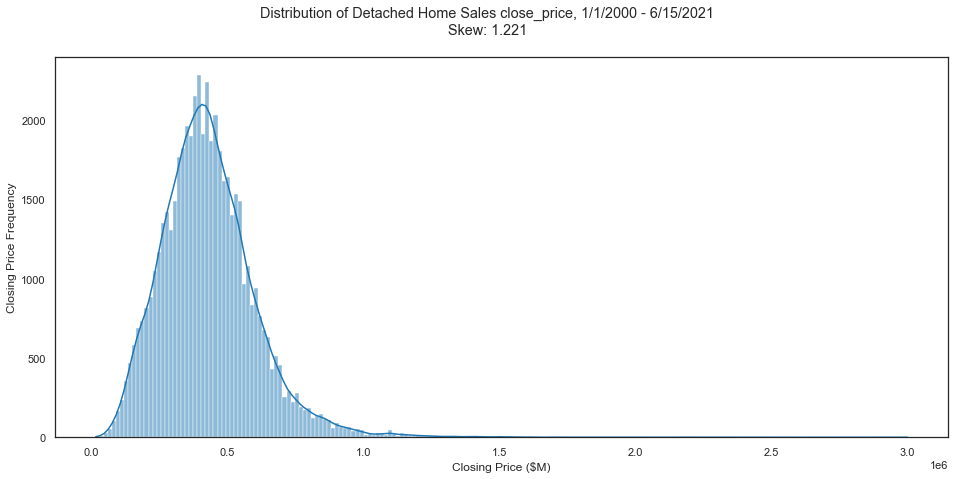

In [54]:
fig1, ax0 = plt.subplots(1, 1, figsize=(16, 7))
fig1.suptitle(f'Distribution of Detached Home Sales close_price, 1/1/2000 - 6/15/2021\n'
              f'Skew: {round(df.close_price.skew(), 3)}')

sns.histplot(data=df,
             x=df.close_price,
             bins= 200,
             kde=True,
             ax = ax0)

ax0.set_xlabel('Closing Price ($M)')
ax0.set_ylabel('Closing Price Frequency')

Plot comparing original close_price and log-transformed close_price distributions.

The log transformation creates a nearly-normal distribution of the closing prices. The skew measurement improved from 1.221 to -0.649. When performing modeling procedures, the closing price variable will need to be log-transformed.

Text(0, 0.5, 'Closing Price Frequency')

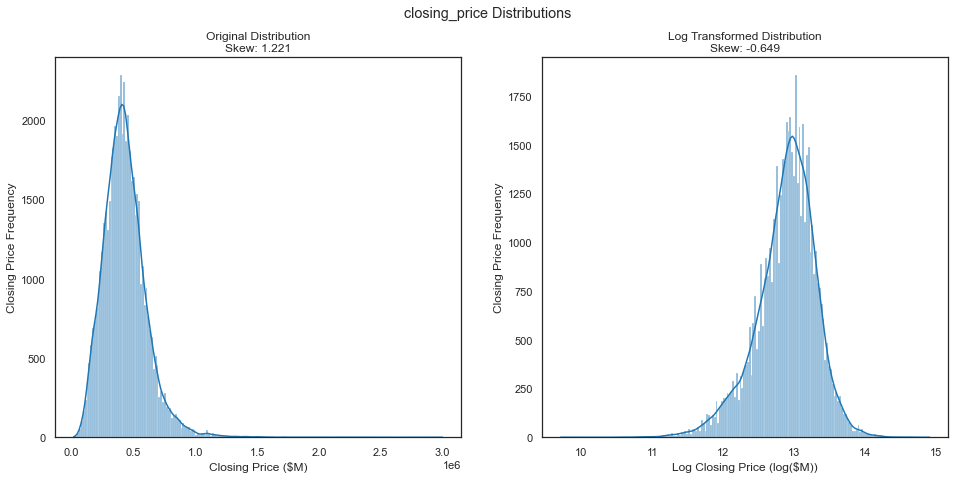

In [55]:
fig2, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 7))
fig2.suptitle('closing_price Distributions')

sns.histplot(data=df,
             x=df.close_price,
             bins= 200,
             kde=True,
             ax = ax0)
ax0.set_title(f'Original Distribution\n'
              f'Skew: {round(df.close_price.skew(), 3)}')
ax0.set_xlabel('Closing Price ($M)')
ax0.set_ylabel('Closing Price Frequency')

sns.histplot(data=df,
             x=np.log(df['close_price']),
             bins= 200,
             kde=True,
             ax = ax1)
ax1.set_title(f'Log Transformed Distribution\n'
              f'Skew: {round(np.log(df.close_price).skew(), 3)}')
ax1.set_xlabel('Log Closing Price (log($M))')
ax1.set_ylabel('Closing Price Frequency')

Create column to calculate the week number of the year that the transaction occurred

In [56]:
df.close_date.head(20)

0    2000-01-03
1    2000-01-04
2    2000-01-06
3    2000-01-06
4    2000-01-06
5    2000-01-06
6    2000-01-07
7    2000-01-07
8    2000-01-07
9    2000-01-10
10   2000-01-10
11   2000-01-10
12   2000-01-10
13   2000-01-12
14   2000-01-12
15   2000-01-12
16   2000-01-13
17   2000-01-14
18   2000-01-14
19   2000-01-14
Name: close_date, dtype: datetime64[ns]

In [57]:
df.close_date.dt.week.head(20)


<ipython-input-57-e386ac10c919>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df.close_date.dt.week.head(20)


0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     2
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
19    2
Name: close_date, dtype: int64

In [58]:
week_nums = []

for date, week in zip(df['close_date'], df['close_date'].dt.strftime('%W')):
    # print(date, week)
    week_nums.append(week)

# print(week_nums)

df['close_week_num'] = week_nums
df['close_week_num'] = df['close_week_num'].astype(int)

In [59]:
df.head(10)

mls_#                    address  zip_code           city  dom  \
0  VAPW289124     10087 Post Oak Terrace   20110.0       Manassas   12   
1  VAPW250326         7409 Howell Run Ct   20112.0       Manassas    1   
2  VAPW284200        8543 Dover Downs Ct   20155.0    Gainesville    5   
3  VAPW289210        10415 Labrador Loop   20112.0       Manassas    3   
4  VAPW292248    7544 Belle Grae Dr #1-5   20109.0       Manassas  456   
5  VAPW250320  9241 Worthington Drive #0   20136.0        Bristow  244   
6  VAPW283942      8640 Sinclair Mill Rd   20112.0       Manassas   30   
7  VAPW283854          13108 Treeline Ct   20112.0       Manassas   60   
8  VAMP106534                132 Yost St   20111.0  Manassas Park   41   
9  VAPW246006              9898 Moore Dr   20111.0       Manassas    1   

  close_date  close_price  beds  bathrooms_full  bathrooms_half  ...  \
0 2000-01-03       304417   4.0             2.0             1.0  ...   
1 2000-01-04       311528   4.0             3.0             1.0  ...   
2 2000-01-06       219500   3.0             2.0             1.0  ...   
3 2000-01-06       199950   4.0             2.0             1.0  ...   
4 2000-01-06        56000   3.0             2.0             NaN  ...   
5 2000-01-06       240000   4.0             2.0             NaN  ...   
6 2000-01-07       129900   3.0             1.0             1.0  ...   
7 2000-01-07       274900   5.0             2.0             1.0  ...   
8 2000-01-07       150000   4.0             2.0             1.0  ...   
9 2000-01-10       146000   3.0             1.0             NaN  ...   

  list_agent_full_name                   list_office_name list_office_code  \
0          John A Dunn            Dunn & Associates, Inc.            DUNN1   
1           Non Member                              Comps            COMP1   
2      Susan M Buckley               Century 21 Champions           CENT70   
3     Shirley R Beyerl  Coldwell Banker Stevens, REALTORS            CBS20   
4           Non Member                              Comps            COMP1   
5           Non Member                              Comps            COMP1   
6     Robert W Forster    Long & Foster Real Estate, Inc.            LNG69   
7       Betty (BJ) Cyr    Long & Foster Real Estate, Inc.            LNG90   
8      George D Greene            Star Homes Realty, Inc.             SHR1   
9        Milagro Lopez         Jack Lawlor Realty Company             JLR2   

   list_office_broker_of_record_id agent_sale_dual   latitude  longitude  \
0                              NaN             0.0  38.729589 -77.502239   
1                              NaN             0.0  38.672901 -77.428282   
2                              NaN             0.0  38.771562 -77.602819   
3                              NaN             0.0  38.728245 -77.480414   
4                              NaN             0.0  38.792258 -77.511938   
5                              NaN             0.0  38.757492 -77.596634   
6                          18809.0             0.0  38.685696 -77.460849   
7                              NaN             0.0  38.672156 -77.435722   
8                              NaN             0.0  38.781766 -77.461825   
9                              NaN             0.0  38.738906 -77.437067   

  close_month close_year close_week_num  
0         1.0     2000.0              1  
1         1.0     2000.0              1  
2         1.0     2000.0              1  
3         1.0     2000.0              1  
4         1.0     2000.0              1  
5         1.0     2000.0              1  
6         1.0     2000.0              1  
7         1.0     2000.0              1  
8         1.0     2000.0              1  
9         1.0     2000.0              2  

[10 rows x 37 columns]

In [60]:
weekly_df = pd.DataFrame(df.groupby(['close_year', 'close_week_num'])['close_price'].describe()).reset_index()
weekly_df.head(10)

close_year  close_week_num  count           mean            std       min  \
0      2000.0               1    9.0  209577.222222   85334.758820   56000.0   
1      2000.0               2   19.0  222457.368421  121831.235634   60000.0   
2      2000.0               3   12.0  234490.000000   92988.885455  104150.0   
3      2000.0               4   25.0  213461.080000   82957.696563   85000.0   
4      2000.0               5   19.0  211914.894737   72331.459758  107500.0   
5      2000.0               6   13.0  254948.846154   93020.124708   89000.0   
6      2000.0               7   13.0  241666.153846  101972.544475   81000.0   
7      2000.0               8   28.0  193274.107143   52933.245330   72000.0   
8      2000.0               9   37.0  231357.270270   80447.552967   93000.0   
9      2000.0              10    8.0  169512.625000   70492.819620   92000.0   

        25%       50%       75%       max  
0  150000.0  219500.0  274900.0  311528.0  
1  141750.0  201000.0  292450.0  560000.0  
2  177500.0  214970.0  291212.5  410000.0  
3  146000.0  209925.0  270000.0  375000.0  
4  166975.0  179900.0  254500.0  415000.0  
5  228000.0  258835.0  305000.0  432000.0  
6  155000.0  247000.0  340824.0  415500.0  
7  170900.0  197200.0  222750.0  312420.0  
8  185000.0  220000.0  265000.0  512210.0  
9  103350.0  172000.0  203175.0  296801.0

[Text(0.5, 1.0, 'Weekly Median and Closing Price ($),\n1/1/2000 - 7/13/2021'),
 Text(0.5, 0, 'Week'),
 Text(0, 0.5, 'Closing Price')]

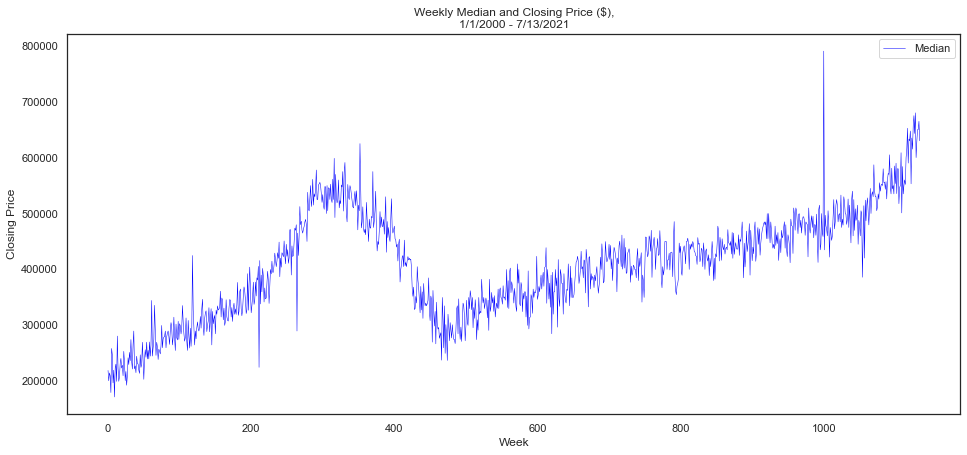

In [61]:
fig3, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.lineplot(data=weekly_df,
             x=weekly_df.index,
             y='50%',
             ax=ax0,
             label='Median',
             color='blue',
             linewidth=0.5)

# sns.lineplot(data=weekly_df,
#              x=weekly_df.index,
#              y='mean',
#              ax=ax0,
#              label='Mean',
#              color='red',
#              linewidth=0.5)

ax0.set(title='Weekly Median and Closing Price ($),\n1/1/2000 - 7/13/2021',
        xlabel='Week',
        ylabel='Closing Price')


[Text(0.5, 1.0, 'Weekly Median Closing Price ($) Distributions\n1/1/2000 - 7/13/2021'),
 Text(0.5, 0, 'Week of Year'),
 Text(0, 0.5, 'Closing Price')]

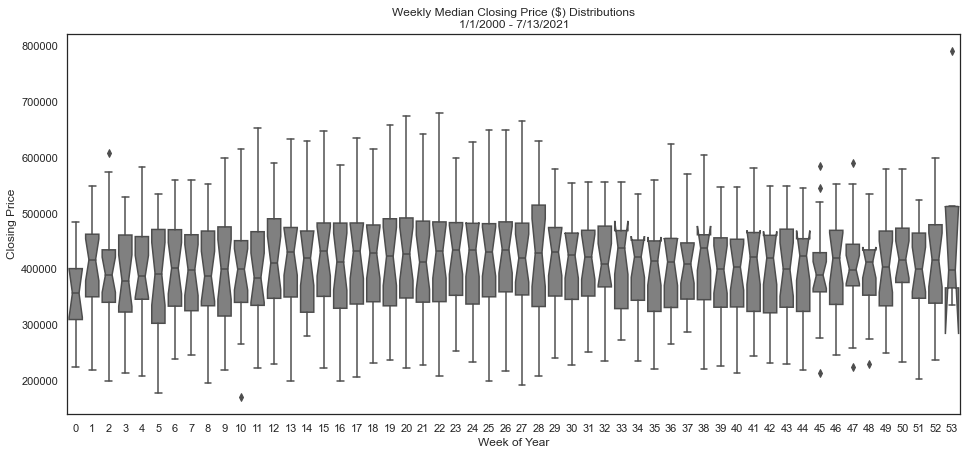

In [62]:
fig4, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.boxplot(data=weekly_df,
            x='close_week_num',
            y='50%',
            color='gray',
            notch=True)

ax0.set(title='Weekly Median Closing Price ($) Distributions\n1/1/2000 - 7/13/2021',
        xlabel='Week of Year',
        ylabel='Closing Price')

In [63]:
monthly_df = pd.DataFrame(df.groupby(['close_year', 'close_month'])['close_price'].describe()).reset_index()
monthly_df.head(10)

close_year  close_month  count           mean            std      min  \
0      2000.0          1.0   76.0  219802.526316   92932.599068  56000.0   
1      2000.0          2.0   95.0  217857.694737   71391.962913  72000.0   
2      2000.0          3.0  113.0  231155.858407   94672.611104  73000.0   
3      2000.0          4.0  136.0  225368.205882   85051.180292  70100.0   
4      2000.0          5.0  169.0  229842.639053   88220.757303  52000.0   
5      2000.0          6.0  193.0  231483.264249   93794.843380  60000.0   
6      2000.0          7.0  162.0  232552.123457   86316.595043  16500.0   
7      2000.0          8.0  191.0  244545.774869   88885.922820  45000.0   
8      2000.0          9.0  124.0  246855.677419  102472.070797  99599.0   
9      2000.0         10.0  146.0  241809.082192   87337.606600  75000.0   

        25%       50%       75%       max  
0  159675.0  206148.0  281212.5  560000.0  
1  170950.0  218000.0  262500.0  432000.0  
2  171000.0  210000.0  277500.0  545000.0  
3  165750.0  212000.0  269964.5  505732.0  
4  171900.0  221500.0  269900.0  549900.0  
5  166000.0  215000.0  274900.0  794758.0  
6  171875.0  229925.0  287750.0  485000.0  
7  184625.0  238000.0  297450.0  495000.0  
8  179225.0  232250.0  293250.0  810000.0  
9  180000.0  229950.0  285460.0  562500.0

[Text(0.5, 1.0, 'Monthly Median and Mean Closing Price ($),\n1/1/2000 - 7/13/2021'),
 Text(0.5, 0, 'Monthly'),
 Text(0, 0.5, 'Closing Price')]

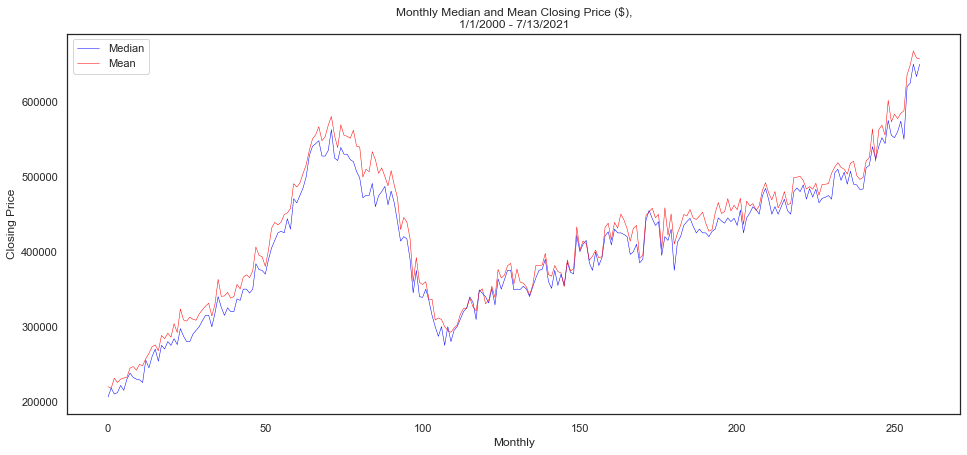

In [64]:
fig5, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.lineplot(data=monthly_df,
             x=monthly_df.index,
             y='50%',
             ax=ax0,
             label='Median',
             color='blue',
             linewidth=0.5)

sns.lineplot(data=monthly_df,
             x=monthly_df.index,
             y='mean',
             ax=ax0,
             label='Mean',
             color='red',
             linewidth=0.5)

ax0.set(title='Monthly Median and Mean Closing Price ($),\n1/1/2000 - 7/13/2021',
        xlabel='Monthly',
        ylabel='Closing Price')

[Text(0.5, 1.0, 'Monthly Median Closing Price ($) Distributions\n1/1/2000 - 7/13/2021'),
 Text(0.5, 0, 'Month of Year'),
 Text(0, 0.5, 'Closing Price')]

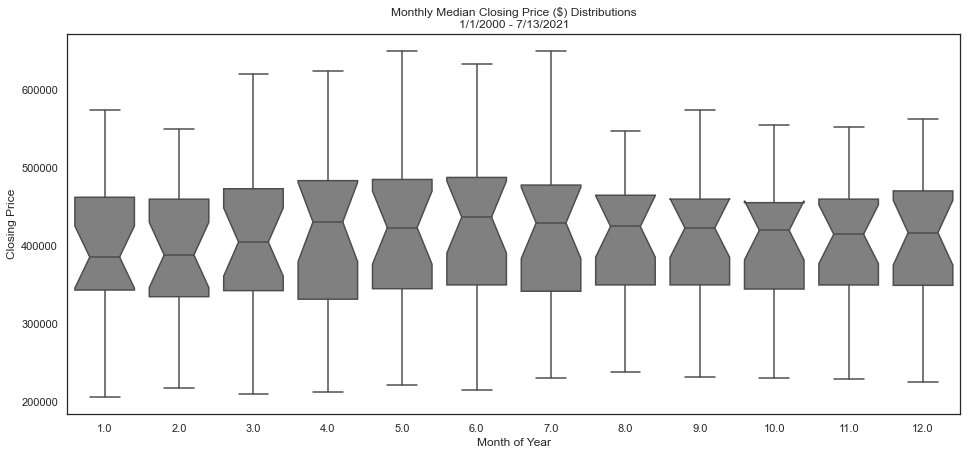

In [65]:
fig6, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.boxplot(data=monthly_df,
            x='close_month',
            y='50%',
            color='gray',
            notch=True)

ax0.set(title='Monthly Median Closing Price ($) Distributions\n1/1/2000 - 7/13/2021',
        xlabel='Month of Year',
        ylabel='Closing Price')

### mls_num

Check for duplicated MLS Numbers. There should not be duplicated MLS Numbers in the dataframe as each transaction should be a unique instance.

The dataframe does not have duplicated MLS Numbers.

In [66]:
df.loc[df['mls_#'].duplicated(keep=False), :]


Empty DataFrame
Columns: [mls_#, address, zip_code, city, dom, close_date, close_price, beds, bathrooms_full, bathrooms_half, subdivision_neighborhood, structure_type, basement, fireplaces_total, levels_stories, total_garage_spaces, above_grade_finished_sqft, below_grade_finished_sqft, condo_coop_assoc_yn, fireplace, garage, hoa_yn, list_price, lot_size_sqft, school_district, total_finished_sqft, year_built, list_agent_full_name, list_office_name, list_office_code, list_office_broker_of_record_id, agent_sale_dual, latitude, longitude, close_month, close_year, close_week_num]
Index: []

[0 rows x 37 columns]

In [67]:
# df.drop_duplicates(subset='mls_#',
#                    keep='first',
#                    ignore_index=True,
#                    inplace=True)


In [68]:
df.reset_index(drop=True, inplace=True)

### address

Create column of concatenated address fields in order to perform geocoding of the address in the future.

In [69]:
df['full_address'] = df.address + ', ' + df.city + ', VA ' + df.zip_code.astype('str')

In [70]:
df.to_csv('data/exports/transactions_full_address.csv')

### zip_code

In [71]:
df.zip_code[0]

20110.0

In [72]:
df['zip_code'] = df['zip_code'].astype(int).astype(str)

In [73]:
df.zip_code[0]

'20110'

In [74]:
print(type(df.zip_code[1]))
df.zip_code.dtypes

<class 'str'>


dtype('O')

In [75]:
df.zip_code.value_counts()

20155    8751
20112    8619
20110    7971
20111    7684
20136    7542
20169    6945
20109    3205
20181    2016
20168      20
20156       2
20108       1
Name: zip_code, dtype: int64

#### Update Zip Codes

Three zip codes are contained wholly within other zip codes. These three zip codes account for only 23 detached sales for the time period covered in this analysis. These three zip codes are being recoded to the larger zip code within which they reside.

20108 -->> 20110

20156 -->> 20155

20168 -->> 20169

In [76]:
df.loc[df.zip_code == '20108', 'zip_code'] = '20110'

In [77]:
df.loc[df.zip_code == '20156', 'zip_code'] = '20155'

In [78]:
df.loc[df.zip_code == '20168', 'zip_code'] = '20169'

In [79]:
print(df.zip_code.dtypes)
df.zip_code.value_counts()

object


20155    8753
20112    8619
20110    7972
20111    7684
20136    7542
20169    6965
20109    3205
20181    2016
Name: zip_code, dtype: int64

Plot the closing prices over the time frame covered in the dataframe.

Over time, the closing prices show an increase between 2000 and ~2006. The trend of the closing price shows the effect of the Housing Bubble popping. Closing prices fall until ~2009.  Beginning ~2009, closing prices begin trending upward until the end of the dataframe (6/15/2021).


Text(0, 0.5, 'Closing Price ($)')

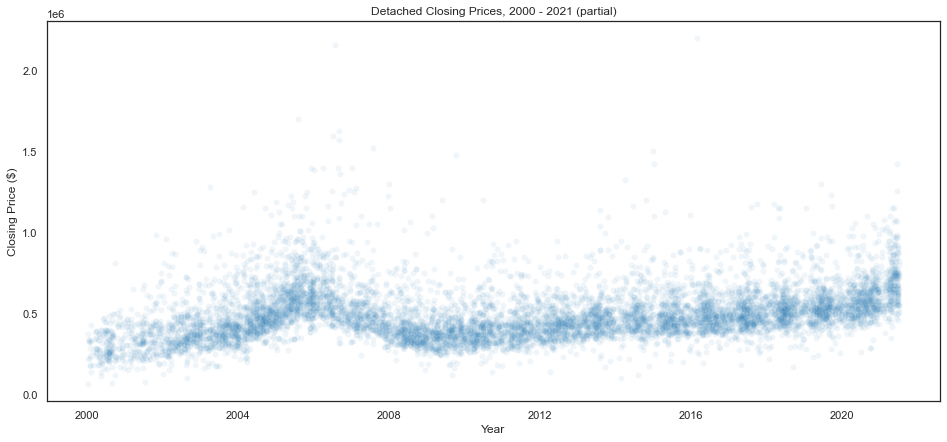

In [80]:
fig7, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(data=df.loc[df['zip_code'] == '20155', :],
                x='close_date',
                y='close_price',
                alpha=0.07,
                ax=ax0)
# plt.axhline(y=575000, ls='--', c='red')
ax0.set_title('Detached Closing Prices, 2000 - 2021 (partial)')
ax0.set_xlabel('Year')
ax0.set_ylabel('Closing Price ($)')

Plotted a boxplot of the closing price for each year contained in the dataframe. This, too, shows the trend contained in the scatterplot above.  This boxplot shows the prevalence of closing price outliers. Every year contains outliers to the top of the boxplots, but only some show outliers on the low side.

The boxplots for 2007 and 2008 exhibit what is likely a significant difference between the housing prices for the two years. The box for 2008 is nearly completely below the box of 2007 and the notches have no overlap.

2021's data only contains sales up until 6/15, but the box indicates that 2021 sales prices are continuing to trend upward, but a rate slightly more aggressive than the previous 10+ years would indicate. 2020 indicated an increased upward trend in closing prices, but 2021 has accelerated that trend.

Text(0, 0.5, 'Closing Price ($M)')

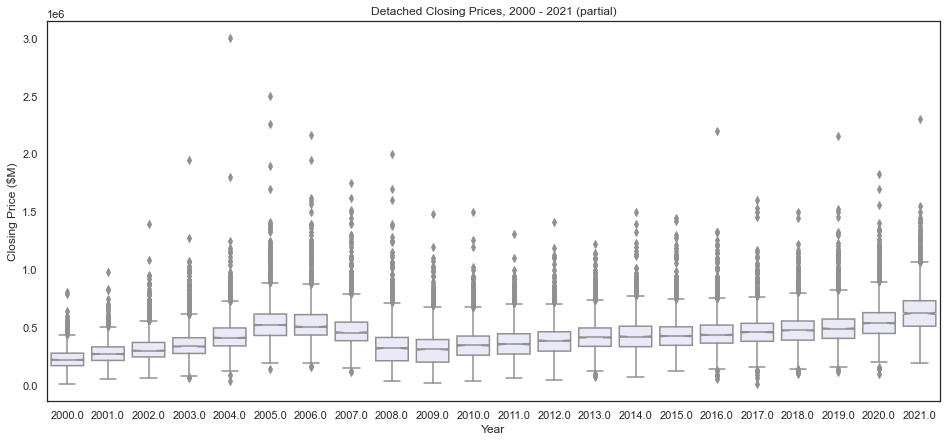

In [81]:
fig8, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.boxplot(data=df,
            x='close_year',
            y='close_price',
            color='lavender',
            notch=True,
            ax=ax0)
ax0.set_title('Detached Closing Prices, 2000 - 2021 (partial)')
ax0.set_xlabel('Year')
ax0.set_ylabel('Closing Price ($M)')

Because the dataframe contains sales data from multiple zip codes, I wanted to see what each zip codes close price vs year looked like. All the zip codes exhibited the same trend, although some zip codes displayed greater variance than others (i.e., 20169 vs 20109 vs. 20181). The differences could be attributed to the number of observations and the fact that a zip code may neighborhoods that generate generally higher close prices than the rest of the zip code.

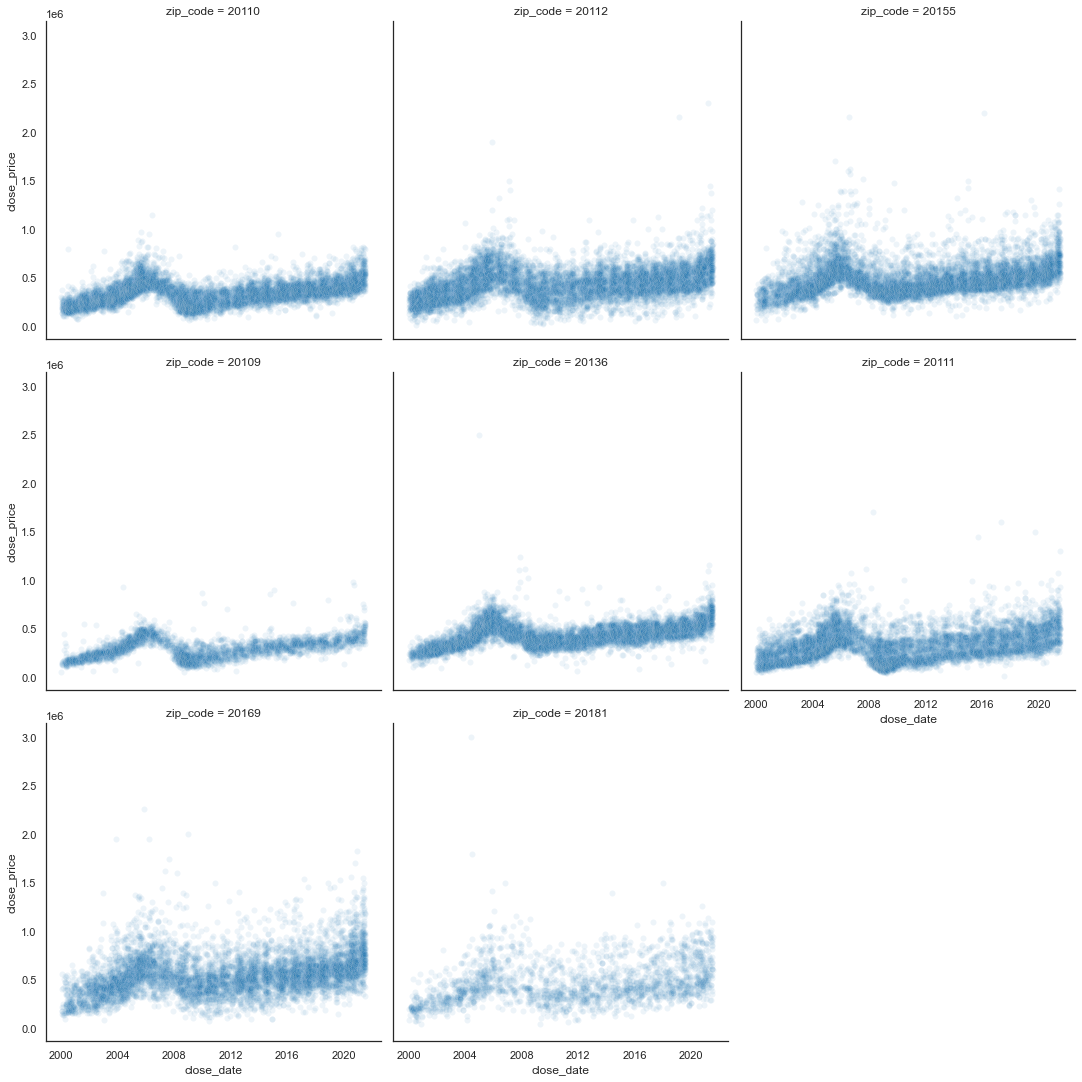

In [82]:
sns.relplot(data=df,
            x='close_date',
            y='close_price',
            kind='scatter',
            col='zip_code',
            col_wrap=3,
            alpha=0.08)

In [83]:
pd.DataFrame(df.groupby(['close_year']).close_price.describe())

count           mean            std       min       25%  \
close_year                                                             
2000.0      1675.0  235896.943284   91498.002039   16500.0  174950.0   
2001.0      2014.0  285760.693148  100945.218542   57000.0  219900.0   
2002.0      2421.0  322151.707972  115150.838292   64900.0  250000.0   
2003.0      2754.0  360712.338417  128322.197602   65000.0  279900.0   
2004.0      3405.0  434824.276652  143417.194973   42000.0  345000.0   
2005.0      3598.0  540681.284047  160470.283471  150000.0  434900.0   
2006.0      2166.0  542538.674054  169807.845067  160000.0  439000.0   
2007.0      1775.0  488592.138592  169439.116357  118000.0  390000.0   
2008.0      2963.0  339137.248734  168713.400024   39900.0  217000.0   
2009.0      2676.0  319250.443572  149564.439482   21500.0  205000.0   
2010.0      2138.0  361067.919551  145278.511550   42500.0  265000.0   
2011.0      1894.0  372057.060718  146882.465840   68000.0  275000.0   
2012.0      2112.0  394938.082386  139745.738583   55000.0  300000.0   
2013.0      2260.0  428184.127434  138899.069924   75000.0  341374.0   
2014.0      2098.0  438083.752145  151060.604680   75000.0  338472.5   
2015.0      2307.0  442280.211530  142552.656418  125000.0  350000.0   
2016.0      2499.0  457117.918768  144252.183838   60000.0  369050.0   
2017.0      2581.0  472774.583107  140384.787412   18000.0  385000.0   
2018.0      2416.0  488241.278974  141154.509900  100000.0  395000.0   
2019.0      2549.0  508562.907415  154425.784993  120000.0  410000.0   
2020.0      2890.0  559055.761592  162540.249520  105000.0  452544.5   
2021.0      1565.0  642198.069010  189425.623973  199000.0  515000.0   

                 50%       75%        max  
close_year                                 
2000.0      224915.0  282482.5   810000.0  
2001.0      274900.0  336762.0   984643.0  
2002.0      304000.0  375000.0  1397500.0  
2003.0      340000.0  415493.0  1950000.0  
2004.0      415000.0  499999.0  3000000.0  
2005.0      525000.0  620000.0  2500000.0  
2006.0      510000.0  614925.0  2159765.0  
2007.0      460000.0  550000.0  1750000.0  
2008.0      325000.0  418005.0  2000000.0  
2009.0      315000.0  400000.0  1480000.0  
2010.0      350000.0  430000.0  1500000.0  
2011.0      360000.0  449900.0  1310000.0  
2012.0      389937.5  467000.0  1410000.0  
2013.0      418000.0  499900.0  1220000.0  
2014.0      425000.0  515000.0  1500000.0  
2015.0      429900.0  510000.0  1450000.0  
2016.0      440000.0  525000.0  2200000.0  
2017.0      463000.0  540000.0  1600000.0  
2018.0      479000.0  560000.0  1500000.0  
2019.0      494000.0  576800.0  2159729.0  
2020.0      540982.5  632000.0  1825000.0  
2021.0      625000.0  735000.0  2300000.0

[Text(0.5, 1.0, 'Annual Median Closing Price ($) For All Zip Codes and Individual Zip Codes\n1/1/2000 - 7/13/2021'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Closing Price ($)')]

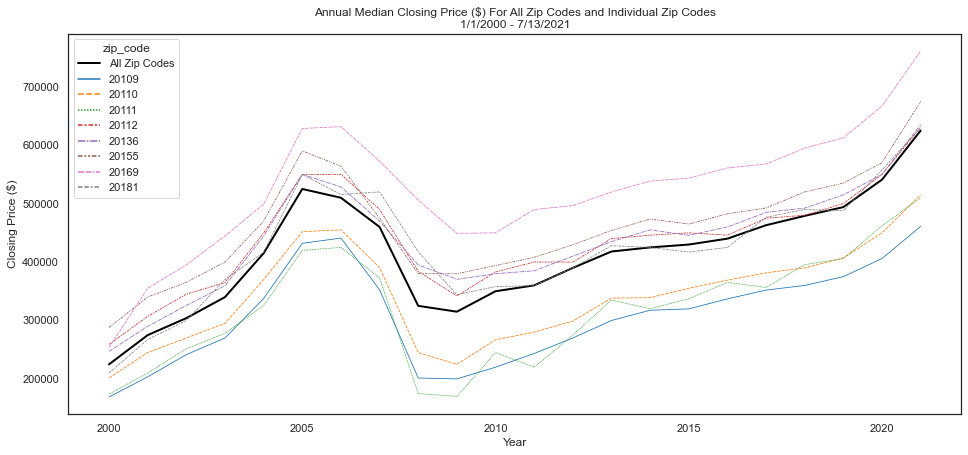

In [84]:
fig9, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.lineplot(data=pd.DataFrame(df.groupby(['close_year']).close_price.describe()),
             x='close_year',
             y='50%',
             ax=ax0,
             label='All Zip Codes',
             color='black',
             lw=2)

sns.lineplot(data=pd.DataFrame(df.groupby(['zip_code', 'close_year']).close_price.describe()),
             x='close_year',
             y='50%',
             hue='zip_code',
             style='zip_code',
             lw=.8)

ax0.set(title='Annual Median Closing Price ($) For All Zip Codes and Individual Zip Codes\n1/1/2000 - 7/13/2021',
        xlabel='Year',
        ylabel='Closing Price ($)')

#### DOM (days on market)

In [85]:
df['dom'] = df.dom.str.replace(',', '', regex=False)

In [86]:
df['dom'] = df.dom.astype(int)

Looking at the days on market variable, it is clear that depending on the month a house goes to closure, there is a difference in the number of days it was on the market for sale. The presence of extreme outliers in the days on market variable (i.e., houses that spent more than 500 days for sale) affected the mean and the standard deviation. Looking at the median is more useful in this instance.

For houses that closed in January and February, 50% of houses were on the market for approximately a month.  Meaning 50% of houses put up for sale in November/December waited about 30 days to achieve a ratified contract between buyer and seller.

For houses that closed in May, 50% of houses were on the market for 14 days, or slightly less than half the time of houses that closed in January and February.

The implication is that houses that are put onto the sale market near the end of April and May tend to spend less time waiting for a ratified contract between buyer and seller than other months of the year.

In general, 50% houses that closed from March through July spent fewer than 20 days on the market. In order to take advantage of the historical closing month trend, houses would need to be placed on the market from January to June due to the general gap between contract ratification and settlement.

In [87]:
pd.DataFrame(df.groupby(['close_month'])['dom'].describe())

count       mean        std  min  25%   50%   75%     max
close_month                                                            
1.0          2964.0  60.065452  85.915776  0.0  9.0  32.0  76.0   751.0
2.0          3084.0  62.591115  95.655519  0.0  8.0  30.0  78.0   861.0
3.0          4225.0  50.971598  82.695030  0.0  6.0  19.0  65.0   805.0
4.0          4574.0  44.028640  74.883882  0.0  5.0  15.0  48.0  1007.0
5.0          5288.0  38.159607  66.918119  0.0  5.0  14.0  40.0   681.0
6.0          6132.0  38.043216  68.098755  0.0  6.0  15.0  40.0   782.0
7.0          5225.0  40.848995  66.604019  0.0  7.0  19.0  46.0   837.0
8.0          5177.0  44.648252  69.357064  0.0  8.0  22.0  55.0  1184.0
9.0          4235.0  48.514994  81.230510  0.0  8.0  23.0  56.0  2239.0
10.0         4127.0  46.508117  68.930820  0.0  8.0  23.0  58.0   860.0
11.0         3661.0  48.824638  71.894605  0.0  7.0  24.0  61.0   837.0
12.0         4064.0  48.171998  68.608056  0.0  6.0  23.0  63.0   993.0

In [88]:
pd.DataFrame(df.groupby(['close_year'])['dom'].describe())

count       mean         std  min   25%   50%    75%     max
close_year                                                               
2000.0      1675.0  56.082388   95.332383  1.0   6.0  19.0   57.0   861.0
2001.0      2014.0  80.032771  129.873827  1.0   7.0  22.0   72.0   679.0
2002.0      2421.0  81.216439  132.238981  0.0  10.0  27.0   77.0  1028.0
2003.0      2754.0  41.356209   65.025982  0.0   6.0  20.0   49.0   840.0
2004.0      3405.0  33.879883   67.995040  0.0   5.0  13.0   33.0   683.0
2005.0      3598.0  34.611729   64.076738  0.0   6.0  15.0   36.0   751.0
2006.0      2166.0  57.698984   60.830821  0.0  14.0  43.0   84.0   583.0
2007.0      1775.0  84.206761   87.447298  0.0  20.0  58.0  120.0   796.0
2008.0      2963.0  68.944313   82.805585  0.0  13.0  39.0   99.5   839.0
2009.0      2676.0  56.328102   95.264853  0.0   9.0  24.0   68.0  2239.0
2010.0      2138.0  40.408326   58.245324  0.0   8.0  20.0   51.0   855.0
2011.0      1894.0  48.893875   64.338077  0.0  11.0  28.0   64.0   742.0
2012.0      2112.0  46.712121   62.858277  0.0   8.0  25.0   59.0   860.0
2013.0      2260.0  36.871681   52.120781  0.0   7.0  19.0   47.0   802.0
2014.0      2098.0  43.893232   53.470024  0.0   9.0  26.0   61.0   659.0
2015.0      2307.0  48.647161   58.001020  0.0  11.0  29.0   67.0   572.0
2016.0      2499.0  45.458984   58.648368  0.0   8.0  26.0   61.0  1007.0
2017.0      2581.0  36.977916   57.309961  0.0   7.0  18.0   47.0  1184.0
2018.0      2416.0  34.440397   48.268132  0.0   7.0  16.0   42.0   524.0
2019.0      2549.0  31.750098   46.166104  0.0   6.0  14.0   40.0   718.0
2020.0      2890.0  18.615225   36.590841  0.0   3.0   6.0   18.0   805.0
2021.0      1565.0   7.729712   21.049185  0.0   3.0   4.0    6.0   599.0

The boxplot without the outliers confirms what is seen in the table above. The medians for March - July are all lower than the other months, which indicate these months are better performers from a days on market context.

The green triangles indicate the average days on market for the month. Because of the number and range of the outliers, the means are all well above their respective medians.

[Text(0.5, 1.0, 'Days on Market Distributions by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Days on Market')]

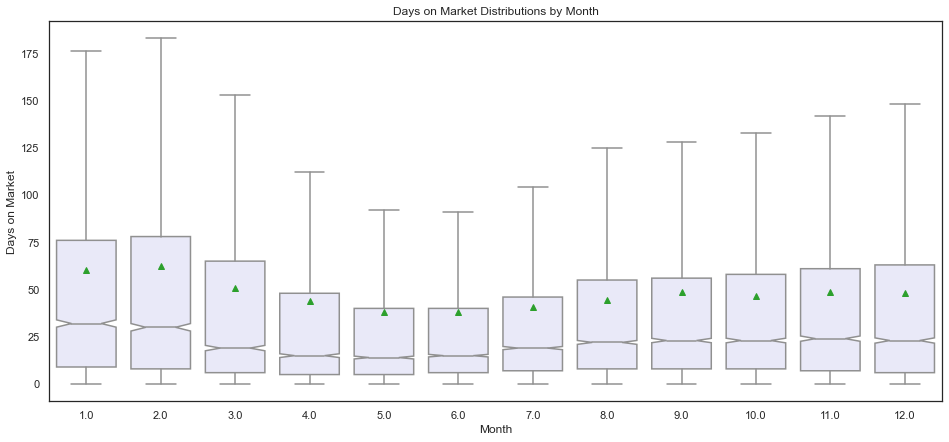

In [89]:
fig10, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.boxplot(data=df,
            x='close_month',
            y='dom',
            color='lavender',
            notch=True,
            showmeans=True,
            showfliers=False,
            ax=ax0)

ax0.set(title='Days on Market Distributions by Month',
        xlabel='Month',
        ylabel='Days on Market')

Text(0, 0.5, 'Frequency')

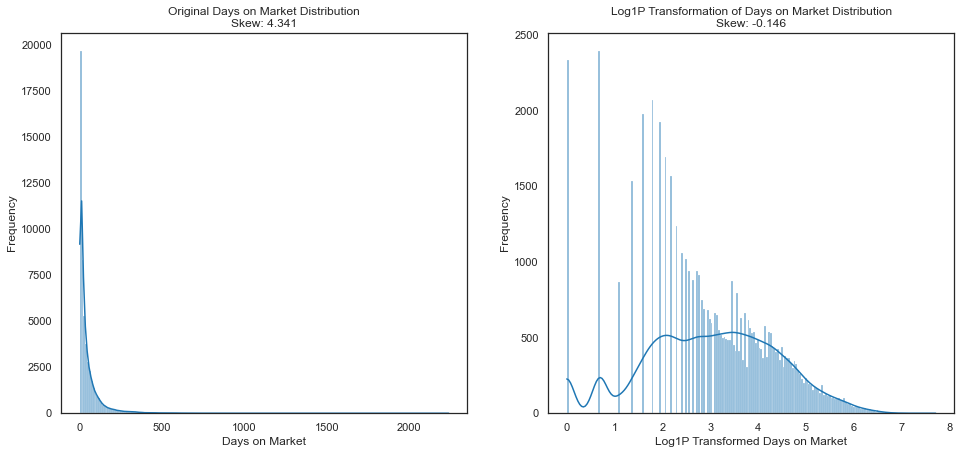

In [90]:
fig11, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 7))

sns.histplot(data=df,
             x='dom',
             kde=True,
             bins=200,
             ax=ax0)
ax0.set_title(f'Original Days on Market Distribution\n'
              f'Skew: {round(df.dom.skew(), 3)}')
ax0.set_xlabel('Days on Market')
ax0.set_ylabel('Frequency')

sns.histplot(data=df,
             x=np.log1p(df['dom']),
             kde=True,
             bins=200,
             ax=ax1)
ax1.set_title(f'Log1P Transformation of Days on Market Distribution\n'
              f'Skew: {round(np.log1p(df.dom).skew(), 3)}')
ax1.set_xlabel('Log1P Transformed Days on Market')
ax1.set_ylabel('Frequency')

Over time, the number of days on the market has generally remained unchanged. When looking at the scatterplot below, there are some interesting areas, 2000-2003, 2007-2010, and the end of 2020-2021.

From 2000-2003, there are several plumes where the number of days on market showed departures from the main cloud of days between 0 and ~100.

from 2007-2009, the scatterplot cloud increases in height, which indicates that houses in general spent more time on the market.  This characteristic of the scatterplot coincides with Housing Bubble popping and the resulting recession.  Based on the scatterplot cloud, there does not appear to a preceding decrease in number of days on the market prior to the market crash, which would have indicated an increasingly active housing market.

Around 2020, the scatterplot cloud becomes compressed, which indicates that the houses that sold, spent less time on the market than the preceding area.  The decrease in days on market indicates that the housing market became hotter.

[Text(0.5, 1.0, 'Days on Market For Every House Sold,\n1/1/2000 - 7/13/2021'),
 Text(0.5, 0, 'Close Date'),
 Text(0, 0.5, 'Days on Market')]

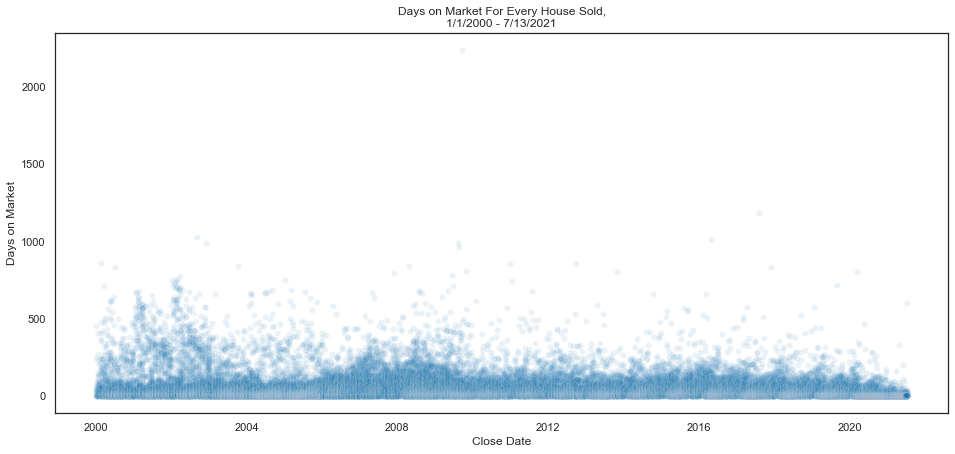

In [91]:
fig12, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(data=df,
                x='close_date',
                y='dom',
                alpha=0.09,
                ax=ax0)

ax0.set(title='Days on Market For Every House Sold,\n1/1/2000 - 7/13/2021',
        xlabel='Close Date',
        ylabel='Days on Market')

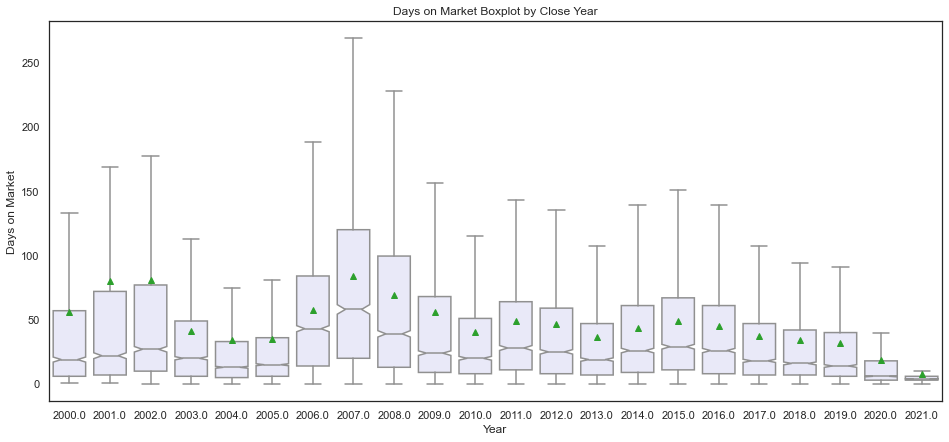

In [92]:
fig13, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.boxplot(data=df,
            x='close_year',
            y='dom',
            color='lavender',
            notch=True,
            showmeans=True,
            showfliers=False,
            ax=ax0)

ax0.set_title('Days on Market Boxplot by Close Year')
ax0.set_xlabel('Year')
ax0.set_ylabel('Days on Market')

fig13.savefig('data/exports/plots/dom_by_year_boxplot.png')

#### HOA

In [93]:
df.rename(columns={'hoa_yn': 'hoa'}, inplace=True)

In [94]:
hoa_map = {'Yes': 1,
           'No': 0}

df['hoa'] = df.hoa.replace(hoa_map).astype('int')

Slightly more than half of the houses in the dataset were a part of an HOA at the time of sale.

In [95]:
hoa_counts = df.hoa.value_counts(dropna=False)
hoa_pcts = df.hoa.value_counts(dropna=False,
                               normalize=True)
pd.concat([hoa_counts, hoa_pcts],
          axis=1,
          keys=['counts', '%'])

counts         %
1   27712  0.525286
0   25044  0.474714

Over the timeframe covered in the dataset, the prevalence of homes sold that were part of an HOA increased and then leveled off. From 2000 to 2005, the percent of homes sold that were part of an HOA increased from ~3% to ~56% and the homes that were not part of an HOA were the complement of those HOA percentages. Since 2005, the percent of homes sold that were part of an HOA has more or less remained stable.

In [96]:
hoa_yr_counts = df.groupby('close_year')['hoa'].value_counts()
hoa_yr_pcts = df.groupby('close_year')['hoa'].value_counts(normalize=True)

hoa_yr_df = pd.concat([hoa_yr_counts, hoa_yr_pcts],
                      axis=1,
                      keys=['counts', '%']).reset_index()
hoa_yr_df

close_year  hoa  counts         %
0       2000.0    0    1621  0.967761
1       2000.0    1      54  0.032239
2       2001.0    0    1495  0.742304
3       2001.0    1     519  0.257696
4       2002.0    0    1677  0.692689
5       2002.0    1     744  0.307311
6       2003.0    0    1814  0.658678
7       2003.0    1     940  0.341322
8       2004.0    0    1781  0.523054
9       2004.0    1    1624  0.476946
10      2005.0    1    2018  0.560867
11      2005.0    0    1580  0.439133
12      2006.0    1    1185  0.547091
13      2006.0    0     981  0.452909
14      2007.0    1    1090  0.614085
15      2007.0    0     685  0.385915
16      2008.0    1    1570  0.529868
17      2008.0    0    1393  0.470132
18      2009.0    1    1427  0.533259
19      2009.0    0    1249  0.466741
20      2010.0    1    1258  0.588400
21      2010.0    0     880  0.411600
22      2011.0    1    1125  0.593981
23      2011.0    0     769  0.406019
24      2012.0    1    1318  0.624053
25      2012.0    0     794  0.375947
26      2013.0    1    1396  0.617699
27      2013.0    0     864  0.382301
28      2014.0    1    1235  0.588656
29      2014.0    0     863  0.411344
30      2015.0    1    1393  0.603814
31      2015.0    0     914  0.396186
32      2016.0    1    1524  0.609844
33      2016.0    0     975  0.390156
34      2017.0    1    1593  0.617203
35      2017.0    0     988  0.382797
36      2018.0    1    1447  0.598924
37      2018.0    0     969  0.401076
38      2019.0    1    1502  0.589251
39      2019.0    0    1047  0.410749
40      2020.0    1    1778  0.615225
41      2020.0    0    1112  0.384775
42      2021.0    1     972  0.621086
43      2021.0    0     593  0.378914

Text(0, 0.5, 'Percent (%)')

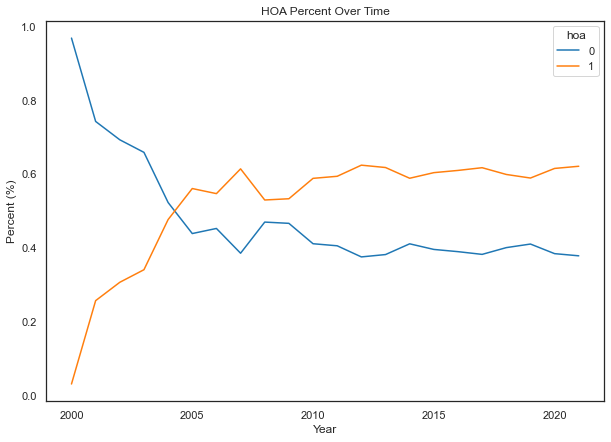

In [97]:
fig14, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.lineplot(data=hoa_yr_df,
             x='close_year',
             y='%',
             hue='hoa',
             ax=ax0)

ax0.set_title('HOA Percent Over Time')
ax0.set_xlabel('Year')
ax0.set_ylabel('Percent (%)')

A scatterplot was used to look at all sales for the previous 20+ years and associated closing price. Then the scatterplot was configured to show in a contrasting color which houses were part of an HOA at the time of sale.

The plot clearly shows that houses in the dataset that were part of an HOA occupied the upper (higher closing price) part of scatterplot.

The scatterplot also shows that prior to ~2005, most houses that were sold were not part of HOA. Then in ~2005-2006 the incidence of sold houses that were part of an HOA increased in density and remained fairly consistent through the end of the dataset.

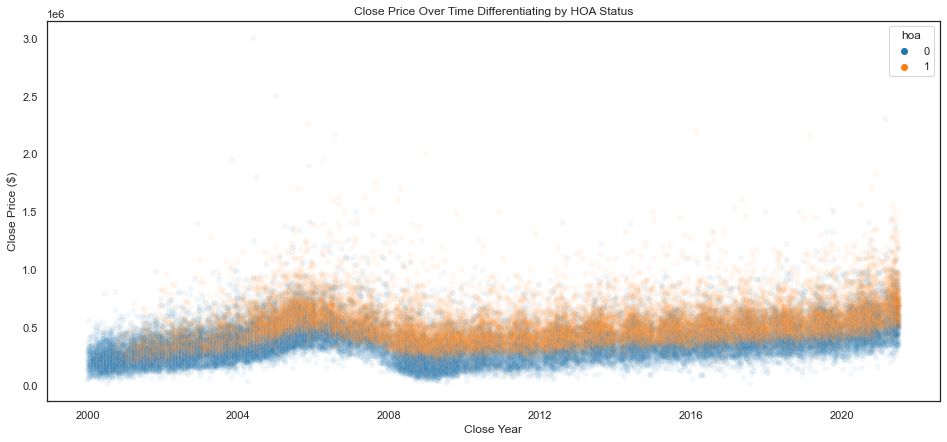

In [98]:
fig15, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(data=df,
                x='close_date',
                y='close_price',
                hue='hoa',
                alpha=0.06,
                ax=ax0)

ax0.set_title('Close Price Over Time Differentiating by HOA Status')
ax0.set_xlabel('Close Year')
ax0.set_ylabel('Close Price ($)')

fig15.savefig('data/exports/plots/close_price_time_hoa_scatterplot.png')

The boxplot below confirms the trend seen in the scatterplot above; the close price for houses in an HOA are higher than the close price for houses that are not in an HOA. The overlap between the two boxes is minimal and the median/notches exhibit no overlap. As a result, HOA is likely a significant variable regarding the closing price of a house from this dataset.

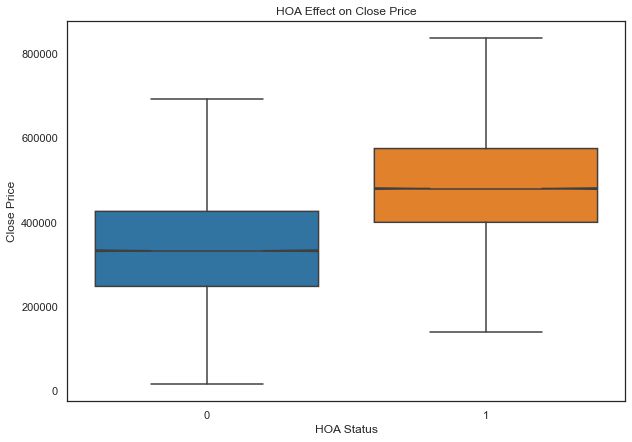

In [99]:
fig16, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.boxplot(data=df,
            x='hoa',
            y='close_price',
            notch=True,
            showfliers=False,
            ax=ax0)

ax0.set_title('HOA Effect on Close Price')
ax0.set_xlabel('HOA Status')
ax0.set_ylabel('Close Price')

fig16.savefig('data/exports/plots/close_price_hoa_boxplot.png')

I plotted a boxplot to investigate whether HOA status produced a possible affect on the number of days on the market. Based on the plot, days on the market between HOA and non-HOA are essentially the same.

Text(0, 0.5, 'Days on Market')

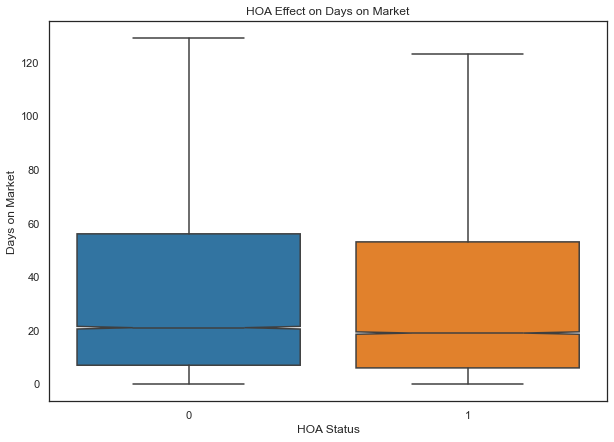

In [100]:
fig17, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.boxplot(data=df,
            x='hoa',
            y='dom',
            notch=True,
            showfliers=False,
            ax=ax0)

ax0.set_title('HOA Effect on Days on Market')
ax0.set_xlabel('HOA Status')
ax0.set_ylabel('Days on Market')

#### Garage

In [101]:
garage_map = {'Yes': 1,
              'No': 0}

In [102]:
df['garage'] = df.garage.replace(garage_map).astype('int')

In [103]:
df.garage.value_counts(dropna=False)

1    40459
0    12297
Name: garage, dtype: int64

#### Garage Spaces

Observe the distribution of total garage spaces

In [104]:
garage_spaces_counts = df.total_garage_spaces.value_counts(dropna=False)
garage_spaces_pcts = df.total_garage_spaces.value_counts(dropna=False,
                                                         normalize=True)

pd.concat([garage_spaces_counts, garage_spaces_pcts],
          axis=1,
          keys=['counts', 'pct'])

counts       pct
2.0    33288  0.630980
NaN    12445  0.235897
1.0     3633  0.068864
3.0     2836  0.053757
4.0      341  0.006464
5.0      106  0.002009
6.0       54  0.001024
0.0       15  0.000284
8.0       12  0.000227
7.0       12  0.000227
9.0        4  0.000076
10.0       4  0.000076
20.0       3  0.000057
12.0       2  0.000038
15.0       1  0.000019

In [105]:
df.loc[df.total_garage_spaces.isnull(), :].head()

mls_#                    address zip_code           city  dom  \
4   VAPW292248    7544 Belle Grae Dr #1-5    20109       Manassas  456   
5   VAPW250320  9241 Worthington Drive #0    20136        Bristow  244   
6   VAPW283942      8640 Sinclair Mill Rd    20112       Manassas   30   
13  VAMP106766             114 Tremont St    20111  Manassas Park    8   
19  VAPW286322        12800 Forest Oak Ct    20112       Manassas   26   

   close_date  close_price  beds  bathrooms_full  bathrooms_half  ...  \
4  2000-01-06        56000   3.0             2.0             NaN  ...   
5  2000-01-06       240000   4.0             2.0             NaN  ...   
6  2000-01-07       129900   3.0             1.0             1.0  ...   
13 2000-01-12        60000   4.0             1.0            15.0  ...   
19 2000-01-14       159000   4.0             3.0             NaN  ...   

                   list_office_name list_office_code  \
4                             Comps            COMP1   
5                             Comps            COMP1   
6   Long & Foster Real Estate, Inc.            LNG69   
13                     Jobin Realty            JOBN2   
19  Long & Foster Real Estate, Inc.            LNG70   

   list_office_broker_of_record_id  agent_sale_dual   latitude  longitude  \
4                              NaN              0.0  38.792258 -77.511938   
5                              NaN              0.0  38.757492 -77.596634   
6                          18809.0              0.0  38.685696 -77.460849   
13                         54012.0              0.0  38.785739 -77.467789   
19                         18809.0              0.0  38.676666 -77.425038   

   close_month close_year close_week_num  \
4          1.0     2000.0              1   
5          1.0     2000.0              1   
6          1.0     2000.0              1   
13         1.0     2000.0              2   
19         1.0     2000.0              2   

                                      full_address  
4    7544 Belle Grae Dr #1-5, Manassas, VA 20109.0  
5   9241 Worthington Drive #0, Bristow, VA 20136.0  
6      8640 Sinclair Mill Rd, Manassas, VA 20112.0  
13       114 Tremont St, Manassas Park, VA 20111.0  
19       12800 Forest Oak Ct, Manassas, VA 20112.0  

[5 rows x 38 columns]

Based on a spotcheck of some of the entries that are NaN, the houses with NaN for total garage spaces are NaN because the real estate agent left the field blank instead of entering in a 0.  I will replace all NaN values in the total garage spaces column with 0.

In [106]:
df.total_garage_spaces.fillna(0,
                              inplace=True)

In [107]:
df.total_garage_spaces.value_counts(dropna=False)

2.0     33288
0.0     12460
1.0      3633
3.0      2836
4.0       341
5.0       106
6.0        54
8.0        12
7.0        12
9.0         4
10.0        4
20.0        3
12.0        2
15.0        1
Name: total_garage_spaces, dtype: int64

### Bathrooms - full

In looking at the distribution of full bathrooms, most houses have between 0 and 7.

In [108]:
bathrooms_full_counts = df.bathrooms_full.value_counts(dropna=False)
bathrooms_full_pcts = df.bathrooms_full.value_counts(dropna=False,
                                                     normalize=True)

pd.concat([bathrooms_full_counts, bathrooms_full_pcts],
          axis=1,
          keys=['counts', '%'])

counts         %
3.0    22258  0.421905
2.0    20122  0.381416
4.0     5580  0.105770
1.0     3587  0.067992
5.0      952  0.018045
6.0      190  0.003601
7.0       36  0.000682
0.0       20  0.000379
21.0       3  0.000057
8.0        2  0.000038
9.0        2  0.000038
20.0       1  0.000019
30.0       1  0.000019
11.0       1  0.000019
13.0       1  0.000019

Several properties have likely erroneous numbers of full bathrooms, for those listings that have more than 7 full bathrooms, the number of full bathrooms will be changed to 7

In [109]:
df.loc[df.bathrooms_full >= 8, 'bathrooms_full'] = 7

In [110]:
df.bathrooms_full.value_counts(dropna=False)

3.0    22258
2.0    20122
4.0     5580
1.0     3587
5.0      952
6.0      190
7.0       47
0.0       20
Name: bathrooms_full, dtype: int64

### Bathrooms - half

In [111]:
bathrooms_half_counts = df.bathrooms_half.value_counts(dropna=False)
bathrooms_half_pcts = df.bathrooms_half.value_counts(dropna=False,
                                                     normalize=True)

pd.concat([bathrooms_half_counts, bathrooms_half_pcts],
          axis=1,
          keys=['counts', '%'])

counts         %
1.0    34848  0.660550
0.0    11354  0.215217
NaN     5134  0.097316
2.0     1367  0.025912
3.0       37  0.000701
4.0        7  0.000133
10.0       4  0.000076
5.0        2  0.000038
13.0       2  0.000038
15.0       1  0.000019

Approximately 1400 listings have null values for half bathrooms. Based on inspection of listings with NaN for the half bathrooms, it appears that agents left the half bathroom field blank instead of putting a 0. I manually updated the NaNs to zero.

In [112]:
df.loc[df.bathrooms_half.isnull(), :]

mls_#                    address zip_code         city  dom  \
4      VAPW292248    7544 Belle Grae Dr #1-5    20109     Manassas  456   
5      VAPW250320  9241 Worthington Drive #0    20136      Bristow  244   
9      VAPW246006              9898 Moore Dr    20111     Manassas    1   
17     VAPW284338             1508 Duffey Dr    20169    Haymarket    9   
19     VAPW286322        12800 Forest Oak Ct    20112     Manassas   26   
...           ...                        ...      ...          ...  ...   
52731  VAPW522318    13206 Triple Crown Loop    20155  Gainesville   18   
52743  VAPW522520         6580 Davis Ford Rd    20111     Manassas    9   
52744  VAPW522314             2539 Youngs Dr    20169    Haymarket    0   
52754  VAMN141788          9173 Firethorn Ct    20110     Manassas    6   
52755  VAPW522940         9614 Lafayette Ave    20109     Manassas    7   

      close_date  close_price  beds  bathrooms_full  bathrooms_half  ...  \
4     2000-01-06        56000   3.0             2.0             NaN  ...   
5     2000-01-06       240000   4.0             2.0             NaN  ...   
9     2000-01-10       146000   3.0             1.0             NaN  ...   
17    2000-01-14       177000   3.0             2.0             NaN  ...   
19    2000-01-14       159000   4.0             3.0             NaN  ...   
...          ...          ...   ...             ...             ...  ...   
52731 2021-06-25       595000   4.0             3.0             NaN  ...   
52743 2021-06-24       510000   4.0             3.0             NaN  ...   
52744 2021-06-23       425000   3.0             2.0             NaN  ...   
52754 2021-06-28       439000   5.0             3.0             NaN  ...   
52755 2021-06-30       349000   4.0             2.0             NaN  ...   

                      list_office_name list_office_code  \
4                                Comps            COMP1   
5                                Comps            COMP1   
9           Jack Lawlor Realty Company             JLR2   
17                Avery-Hess, REALTORS             AHR7   
19     Long & Foster Real Estate, Inc.            LNG70   
...                                ...              ...   
52731                Samson Properties            SAMP9   
52743               Weichert, REALTORS            WEI48   
52744               Weichert, REALTORS            WEI49   
52754               Wise Choice Realty            WCHC1   
52755                 Yeti Realty, LLC            YETI1   

      list_office_broker_of_record_id  agent_sale_dual   latitude  longitude  \
4                                 NaN              0.0  38.792258 -77.511938   
5                                 NaN              0.0  38.757492 -77.596634   
9                                 NaN              0.0  38.738906 -77.437067   
17                             2952.0              0.0  38.927108 -77.660174   
19                            18809.0              0.0  38.676666 -77.425038   
...                               ...              ...        ...        ...   
52731                       3015801.0              0.0  38.825142 -77.604114   
52743                         51175.0              0.0  38.725176 -77.405508   
52744                         51175.0              0.0  38.902032 -77.667619   
52754                        108051.0              0.0  38.771649 -77.475272   
52755                       3320366.0              0.0  38.787573 -77.488299   

      close_month close_year close_week_num  \
4             1.0     2000.0              1   
5             1.0     2000.0              1   
9             1.0     2000.0              2   
17            1.0     2000.0              2   
19            1.0     2000.0              2   
...           ...        ...            ...   
52731         6.0     2021.0             25   
52743         6.0     2021.0             25   
52744         6.0     2021.0             25   
52754         6.0     2021.0             26   
52755      

In [113]:
df.bathrooms_half.fillna(0,
                         inplace=True)

In [114]:
df.bathrooms_half.value_counts(dropna=False)


1.0     34848
0.0     16488
2.0      1367
3.0        37
4.0         7
10.0        4
5.0         2
13.0        2
15.0        1
Name: bathrooms_half, dtype: int64

Approximately 10 listings have 10 or more half bathrooms. Listings with 4 or more half bathrooms will be manually changed to 4 half bathrooms

In [115]:
df.loc[df.bathrooms_half >= 4, 'bathrooms_half'] = 4

In [116]:
df.bathrooms_half.value_counts(dropna=False)

1.0    34848
0.0    16488
2.0     1367
3.0       37
4.0       16
Name: bathrooms_half, dtype: int64

#### Fireplaces_total

In [117]:
df.fireplaces_total.value_counts(dropna=False)

1.0      37610
0.0       8205
2.0       4866
NaN       1228
3.0        670
4.0        121
5.0         34
6.0          5
11.0         4
13.0         4
7.0          3
8.0          2
9.0          1
10.0         1
108.0        1
12.0         1
Name: fireplaces_total, dtype: int64

Approximately 1228 listings have null values for total number of fireplaces. Upon inspection, some houses with NaN truly have no fireplaces while some houses do have fireplaces. As a result of the inconsistency in the data, the NaNs will be dropped from the dataframe.

In [118]:
df.loc[df.fireplaces_total.isnull(), :]

mls_#                address zip_code           city  dom  \
43733  VAPW240082     13080 Twin Leaf Dr    20181     Nokesville    0   
44824  VAPW470712    5655 Hoadly View Ct    20112       Manassas    0   
45432  VAPW321168     9377 Silvermist Ln    20111       Manassas    0   
45541  VAPW190144  4521 Gyser Creek Loop    20169      Haymarket    0   
45606  VAPW101178          8022 Mace Cir    20111       Manassas    1   
...           ...                    ...      ...            ...  ...   
52737  VAMN141796      10325 Sarajevo Ct    20110       Manassas    5   
52738  VAMP114830          112 Runyon Ct    20111  Manassas Park   14   
52742  VAPW522350         8056 Gracie Dr    20112       Manassas    6   
52754  VAMN141788      9173 Firethorn Ct    20110       Manassas    6   
52755  VAPW522940     9614 Lafayette Ave    20109       Manassas    7   

      close_date  close_price  beds  bathrooms_full  bathrooms_half  ...  \
43733 2018-03-29       469990   5.0             3.0             1.0  ...   
44824 2018-07-31       664894   5.0             3.0             0.0  ...   
45432 2018-10-31       535810   4.0             3.0             0.0  ...   
45541 2018-11-21       684241   4.0             4.0             1.0  ...   
45606 2018-11-30       260000   4.0             2.0             0.0  ...   
...          ...          ...   ...             ...             ...  ...   
52737 2021-06-25       490000   4.0             2.0             1.0  ...   
52738 2021-07-07       375000   4.0             1.0             1.0  ...   
52742 2021-06-25       517000   3.0             2.0             1.0  ...   
52754 2021-06-28       439000   5.0             3.0             0.0  ...   
52755 2021-06-30       349000   4.0             2.0             0.0  ...   

                                    list_office_name list_office_code  \
43733                      Century 21 New Millennium         CENT2015   
44824                         Non Subscribing Office             NON1   
45432  Berkshire Hathaway HomeServices PenFed Realty            PFED6   
45541                      Century 21 New Millennium         CENT2015   
45606                  Spring Hill Real Estate, LLC.            SHIL1   
...                                              ...              ...   
52737                        Trusst Residential, LLC           TRUSS1   
52738                             Vera's Realty Inc.             VER1   
52742                             Weichert, REALTORS             WEI4   
52754                             Wise Choice Realty            WCHC1   
52755                               Yeti Realty, LLC            YETI1   

      list_office_broker_of_record_id  agent_sale_dual   latitude  longitude  \
43733                        130778.0              0.0  38.700013 -77.550571   
44824                             NaN              0.0  38.672719 -77.379434   
45432                         69302.0              0.0  38.751323 -77.446845   
45541                        130778.0              0.0  38.859599 -77.645574   
45606                        110837.0              0.0  38.779769 -77.479695   
...                               ...              ...        ...        ...   
52737                         73670.0              0.0  38.730501 -77.470461   
52738                         30099.0              0.0  38.783150 -77.463065   
52742                         51175.0              0.0  38.656534 -77.451367   
52754                        108051.0              0.0  38.771649 -77.475272   
52755                       3320366.0              0.0  38.787573 -77.488299   

      close_month close_year close_week_num  \
43733         3.0     2018.0             13   
44824         7.0     2018.0             31   
45432        10.0     2018.0             44   
45541        11.0     2018.0             47   
45606        11.0     2018.0             48   
...           ...        ...            ...   
52737         6.0     2021.0             25   
52738   

In [119]:
df = df.loc[df.fireplaces_total.notnull(), :]

In [120]:
df.fireplaces_total.value_counts(dropna=False)

1.0      37610
0.0       8205
2.0       4866
3.0        670
4.0        121
5.0         34
6.0          5
11.0         4
13.0         4
7.0          3
8.0          2
9.0          1
10.0         1
108.0        1
12.0         1
Name: fireplaces_total, dtype: int64

Perform spotcheck of those houses that have 10 or more fireplaces.

14389 Newbern Loop, Gainseville incorrectly has 108 fireplaces, rather it should be 1
7517 Albermarle Dr, Manassas incorrectly has 10 fireplaces, rather it appears to be 1
5904 Flynnsbrooke Ter, Haymarket incorrectly has 11 fireplaces, rather it should be 2 for a double-sided fireplace
9612 Waterford Dr, Manassas incorrectly has 11 fireplaces, rather it should be 1
15270 Fog Mountain Cir, Haymarket incorrectly has 11 fireplaces, rather it should be 1
13776 Coronado Ct, Manassas incorrectly has 13 fireplaces, rather it should be 1 based on satellite picture
6017 River Forest Dr, Manassas incorrectly has 11 fireplaces, rather it should be 1
10063 Esteppe Dr, Manassas incorrectly has 13 fireplaces, rather it should be 1 based on satellite picture
12928 Larkmeade Ln Manassas incorrectly has 13 fireplaces, rather it will be 1 based on previous trends and lack of pictures
17045 Duck Ln, Haymarket incorrectly has 12 fireplaces, rather it should be 1
12932 Champlain Dr, Manassas incorrectly has 13 fireplaces, rather it should be 1


In [121]:
print(df.loc[df.fireplaces_total >= 10, ['address', 'city', 'fireplaces_total']].to_string())

                      address         city  fireplaces_total
17161       7517 Albemarle Dr     Manassas              10.0
18316   5904 Flynnsbrooke Ter    Haymarket              11.0
20302      14389 Newbern Loop  Gainesville             108.0
24304       9612 Waterford Dr     Manassas              11.0
26327       13776 Coronado Ct     Manassas              13.0
27512  15270 Fog Mountain Cir    Haymarket              11.0
28130        10063 Esteppe Dr     Manassas              13.0
28187    6017 River Forest Dr     Manassas              11.0
31070      12928 Larkmeade Ln     Manassas              13.0
39520           17045 Duck Ln    Haymarket              12.0
41487      12932 Champlain Dr     Manassas              13.0


In [122]:
df.loc[df.fireplaces_total >= 10, 'fireplaces_total'] = 1

In [123]:
df.fireplaces_total.value_counts(dropna=False)

1.0    37621
0.0     8205
2.0     4866
3.0      670
4.0      121
5.0       34
6.0        5
7.0        3
8.0        2
9.0        1
Name: fireplaces_total, dtype: int64

#### Condo_Coop_Assoc_YN

In [124]:
df.rename(columns={'condo_coop_assoc_yn': 'condo_coop_assoc'},
          inplace=True)

In [125]:
df.condo_coop_assoc.value_counts(dropna=False)

No     51516
Yes        9
NaN        3
Name: condo_coop_assoc, dtype: int64

Three listings have a null value for condo_coop_assoc. Upon inspection of these:

9547 Laurencekirk Pl, Bristow is not a condo_coop so it will be changed to No

12868 Vint Hill Rd, Nokesville is not a condo_coop so it will be changed to No

8163 Snead Loop, Gainesville is not a condo_coop so it will be changed to No

In [126]:
df.condo_coop_assoc.fillna('No',
                           inplace=True)

In [127]:
df.condo_coop_assoc.value_counts(dropna=False)


No     51519
Yes        9
Name: condo_coop_assoc, dtype: int64

In [128]:
condo_coop_map = {'Yes': 1,
                  'No': 0}

In [129]:
df['condo_coop_assoc'] = df['condo_coop_assoc'].replace(condo_coop_map)

In [130]:
df.condo_coop_assoc.value_counts(dropna=False)

0    51519
1        9
Name: condo_coop_assoc, dtype: int64

#### Basement

For all houses sold between 1/1/2000 and 7/13/2021, 83% of all houses had a basement. This does not account for finished vs unfinished basements or square footage, just whether or not a house had a basement.

In [131]:
basement_counts = df.basement.value_counts(dropna=False)
basement_pcts = df.basement.value_counts(dropna=False,
                                         normalize=True)

pd.concat([basement_counts, basement_pcts],
          axis=1,
          keys=['counts', '%'])

counts         %
Yes   43180  0.837991
No     8348  0.162009

In [132]:
basement_map = {'Yes': 1,
                'No': 0}

In [133]:
df['basement'] = df.basement.replace(basement_map)

In [134]:
df.basement.value_counts(dropna=False)

1    43180
0     8348
Name: basement, dtype: int64

### Levels_stories

65 houses have no reported levels or stories, which does not seem plausible. I performed a spotcheck of those houses that have NaNs. Based on investigation, some of the listings are for plots of land, some are houses with one level and others are multileveled houses. Because of the inconsistency of the listings, they will be dropped from the dataframe.

In [135]:
df.levels_stories.value_counts(dropna=False)

3+       32456
2        12847
1         3148
3         2918
NaN         65
4           45
2.5         20
1.5         14
Other        7
3.5          6
5            2
Name: levels_stories, dtype: int64

In [136]:
df.loc[df.levels_stories.isnull(), ['address', 'city', 'levels_stories']]

address         city levels_stories
1587            8920 June St     Manassas            NaN
1593         9593 Magenta St     Manassas            NaN
1681     12000 Young Tree Ct      Bristow            NaN
1702       10379 Navarone Pl     Manassas            NaN
1703      14820 Cox Creek Ct    Haymarket            NaN
...                      ...          ...            ...
30477    9252 Beauregard Ave     Manassas            NaN
31753       7209 Winnipeg Ct  Gainesville            NaN
33000  10025 Spindle Foot Ct      Bristow            NaN
34377  10906 Lake Jackson Dr     Manassas            NaN
38490         9408 Lomond Dr     Manassas            NaN

[65 rows x 3 columns]

In [137]:
df.loc[df.levels_stories.notnull(), :]

mls_#                  address zip_code         city  dom  \
0      VAPW289124   10087 Post Oak Terrace    20110     Manassas   12   
1      VAPW250326       7409 Howell Run Ct    20112     Manassas    1   
2      VAPW284200      8543 Dover Downs Ct    20155  Gainesville    5   
3      VAPW289210      10415 Labrador Loop    20112     Manassas    3   
4      VAPW292248  7544 Belle Grae Dr #1-5    20109     Manassas  456   
...           ...                      ...      ...          ...  ...   
52749  VAPW522440      15705 Rothschild Ct    20169    Haymarket    6   
52750  VAPW525310   15160 Jupiter Hills Ln    20169    Haymarket    3   
52751  VAPW521352   13130 Carriage Ford Rd    20181   Nokesville    5   
52752  VAPW524372       10209 Inchberry Ct    20136      Bristow    6   
52753  VAPW514438      9128 Acadia Park Dr    20136      Bristow    4   

      close_date  close_price  beds  bathrooms_full  bathrooms_half  ...  \
0     2000-01-03       304417   4.0             2.0             1.0  ...   
1     2000-01-04       311528   4.0             3.0             1.0  ...   
2     2000-01-06       219500   3.0             2.0             1.0  ...   
3     2000-01-06       199950   4.0             2.0             1.0  ...   
4     2000-01-06        56000   3.0             2.0             0.0  ...   
...          ...          ...   ...             ...             ...  ...   
52749 2021-06-21       870000   5.0             3.0             1.0  ...   
52750 2021-07-09       700000   4.0             3.0             1.0  ...   
52751 2021-06-28       895000   4.0             4.0             1.0  ...   
52752 2021-07-07       685000   4.0             2.0             1.0  ...   
52753 2021-06-30       820000   4.0             4.0             1.0  ...   

                        list_office_name list_office_code  \
0                Dunn & Associates, Inc.            DUNN1   
1                                  Comps            COMP1   
2                   Century 21 Champions           CENT70   
3      Coldwell Banker Stevens, REALTORS            CBS20   
4                                  Comps            COMP1   
...                                  ...              ...   
52749                 Weichert, REALTORS            WEI49   
52750                 Weichert, REALTORS            WEI58   
52751                 Weichert, REALTORS            WEI58   
52752                 Weichert, REALTORS            WEI69   
52753                 Weichert, REALTORS            WEI69   

       list_office_broker_of_record_id  agent_sale_dual   latitude  longitude  \
0                                  NaN              0.0  38.729589 -77.502239   
1                                  NaN              0.0  38.672901 -77.428282   
2                                  NaN              0.0  38.771562 -77.602819   
3                                  NaN              0.0  38.728245 -77.480414   
4                                  NaN              0.0  38.792258 -77.511938   
...                                ...              ...        ...        ...   
52749                          51175.0              0.0  38.833891 -77.654555   
52750                          51175.0              0.0  38.831524 -77.644221   
52751                          51175.0              0.0  38.672182 -77.587255   
52752                          51175.0              0.0  38.734527 -77.585500   
52753                          51175.0              0.0  38.757925 -77.571293   

      close_month close_year  close_week_num  \
0             1.0     2000.0               1   
1             1.0     2000.0               1   
2             1.0     2000.0               1   
3             1.0     2000.0               1   
4             1.0     2000.0               1   
...           ...        ...             ...   
52749         6.0     2021.0              25   
52750         7.0     2021.0              27   
52751         6.0     2021.0              26   
52752         7.0     2021.0        

In [138]:
df = df.loc[df.levels_stories.notnull(), :]

In [139]:
df.levels_stories.value_counts(dropna=False)

3+       32456
2        12847
1         3148
3         2918
4           45
2.5         20
1.5         14
Other        7
3.5          6
5            2
Name: levels_stories, dtype: int64

Investigate the listings that have 'other' as the number of levels. Based on a spotcheck, houses with 'other' will be manually changed to 4 levels and stories. This is due to the inconsistency of the data. These houses appear to have multiple stories and levels.

In [140]:
df.loc[df.levels_stories == 'Other', ['address', 'city', 'levels_stories']]

address         city levels_stories
45489  12168 Rain Slicker Pl   Nokesville          Other
45934  8905 Ruffed Grouse Ct  Gainesville          Other
46030      9905 Greenview Ln     Manassas          Other
47029       6082 Cantwell St  Gainesville          Other
47564  11712 Robert E Lee Dr      Bristow          Other
48125      8380 Mary Jane Dr     Manassas          Other
48660        6655 Fayette St    Haymarket          Other

There is no consistency to what a level or story constitutes, which is why there is a prevalence of 1.5, 2.5, and 3.5 levels.  In order to bring a sense of logic to the levels and stories of a house, a house can have between 1 and 4 levels or stories. Houses with a half level or story get rounded up to the next whole number level or story. Houses with 3.5, other or more levels or stories is capped at 4 levels.

In [141]:
df.loc[df.levels_stories == 1, 'levels_stories'] = 1
df.loc[df.levels_stories == '1', 'levels_stories'] = 1
df.loc[df.levels_stories == 1.5, 'levels_stories'] = 2
df.loc[df.levels_stories == '1.5', 'levels_stories'] = 2
df.loc[df.levels_stories == 2, 'levels_stories'] = 2
df.loc[df.levels_stories == '2', 'levels_stories'] = 2
df.loc[df.levels_stories == 2.5, 'levels_stories'] = 3
df.loc[df.levels_stories == '2.5', 'levels_stories'] = 3
df.loc[df.levels_stories == 3, 'levels_stories'] = 3
df.loc[df.levels_stories == '3', 'levels_stories'] = 3
df.loc[df.levels_stories == 3.5, 'levels_stories'] = 4
df.loc[df.levels_stories == '3.5', 'levels_stories'] = 4
df.loc[df.levels_stories == '3+', 'levels_stories'] = 3
df.loc[df.levels_stories == 4, 'levels_stories'] = 4
df.loc[df.levels_stories == '4', 'levels_stories'] = 4
df.loc[df.levels_stories == '5', 'levels_stories'] = 4
df.loc[df.levels_stories == 'Other', 'levels_stories'] = 4

In [142]:
df['levels_stories'] = df['levels_stories'].astype(float)

In [143]:
df.levels_stories.describe()

count    51463.000000
mean         2.628918
std          0.598381
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: levels_stories, dtype: float64

In [144]:
df.levels_stories.value_counts(dropna=False)

3.0    35394
2.0    12861
1.0     3148
4.0       60
Name: levels_stories, dtype: int64

#### Year

Clearly there are data entry mistakes in the dataset regarding the year a house was built.  Many of the houses that claim to be built prior to 1960 don't appear to be from that time period based on visual inspection.

In [145]:
df.year_built.value_counts(dropna=False)

2005.0    3122
2001.0    3049
2004.0    2839
2002.0    2734
2003.0    2701
          ... 
1815.0       1
1896.0       1
1898.0       1
1765.0       1
1793.0       1
Name: year_built, Length: 139, dtype: int64

14 houses have NaN values for the year in which the house was built. Because of the NaN value, the house will be dropped from the dataset.

In [146]:
df.year_built.isnull().sum()

14

In [147]:
df = df.loc[df.year_built.notnull(), :]

This histogram below shows how the majority of houses were built recently.  The histogram also shows that there are outlier houses whose built year was 0. Houses with a built year of 0 will be dropped.

<AxesSubplot:ylabel='Frequency'>

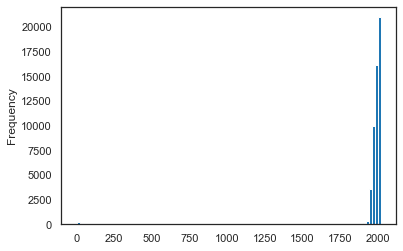

In [148]:
df.year_built.plot(kind='hist', bins=100)

In [149]:
df = df.loc[df.year_built != 0, :]

After dropping houses whose built in year was 0, the resulting histogram shows that the majority of houses were built after 1950. Houses which claim to have been built in 1949 or before will be dropped from the dataset

Text(0, 0.5, 'Frequency')

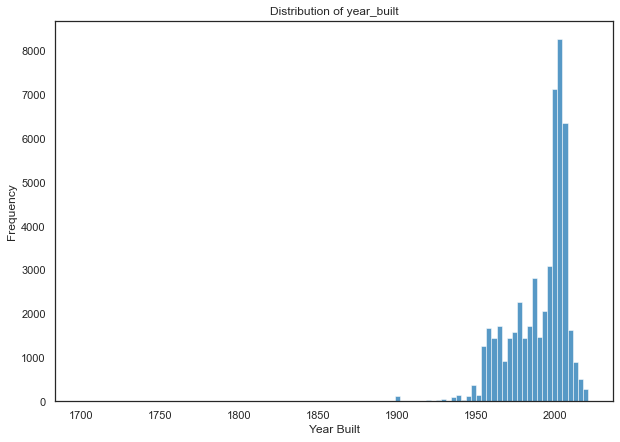

In [150]:
fig18, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.histplot(data=df,
             x='year_built',
             bins=100,
             ax=ax0)

ax0.set_title('Distribution of year_built')
ax0.set_xlabel('Year Built')
ax0.set_ylabel('Frequency')

In [151]:
df = df.loc[df.year_built > 1949, :]

After dropping houses whose listed year built date was prior to 1950, the distribution of houses sold shows that the majority of sold houses were built between 2000 and 2010.

Text(0, 0.5, 'Frequency')

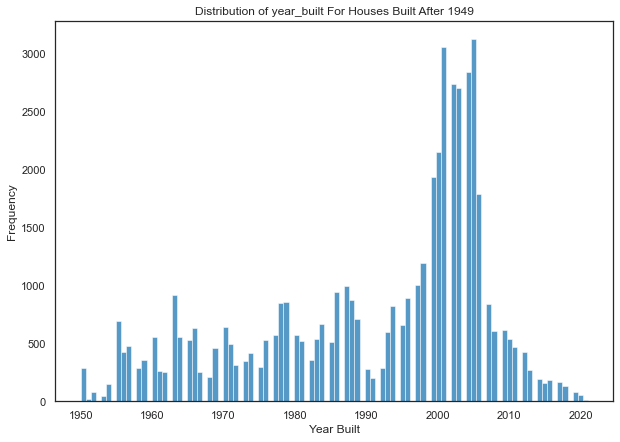

In [152]:
fig19, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.histplot(data=df,
             x='year_built',
             bins=100,
             ax=ax0)

ax0.set_title('Distribution of year_built For Houses Built After 1949')
ax0.set_xlabel('Year Built')
ax0.set_ylabel('Frequency')

#### List price and creation of column to show % change from list to close prices

The dataset contains the list price and the price at which the house ultimately sold for. Because both datapoints are available, it's possible to determine the % above or below the house sold for relative to its listing price.

In [153]:
df['list_price'] = df.list_price.str.replace('$', '', regex=False)
df['list_price'] = df.list_price.str.replace(',', '')
df['list_price'] = df.list_price.str.split('.', 1, expand=True)[0].astype(int)

The derived close_list_delta column calculates the change from the list price to the close price. When a value is positive, it indicates that the close price was higher than the list price. When a value is negative, the close price was lower than the listing price.

This value can be used as a metric to measure both market and real estate agent performance. If the value for a house in this column is 0, then the real estate agent correctly determined what the market would bear for a house of given characteristics.  In this situation, the seller profits the amount of money that was anticipated at the time of placing the house on the market for sale.

If the value for a house in this column is positive, the agent may have accurately determined what the market would bear for that house, but if the market is in a 'seller's market' then the house price was bid up in a bidding war.  If there was no bidding war, the prospective buyer may have made an offer higher than the list price in an anticipatory move to win the house before any other buyers could make an offer. Here, the seller profits more money than was anticipated at the time of placing the house on the market for sale.

If the value for a house in this column is negative, the agent may have miscalculated what the market would bear for a house of those characteristics. Here the seller profits less money than was anticipated at the time of placing the house on the market for sale.

It must also be noted that depending on the transaction of interest, buying or selling a house, the change in list price to close price may have different meanings. A buyer is interested paying the lowest amount possible whereas the seller prefers to sell at the list price or higher. So, it must be acknowledged that the perspective of the parties involved can change the interpretation of what the numbers represent.

In [154]:
df['close_list_delta'] = ((df.close_price - df.list_price) / df.list_price)

In [155]:
df.head(10)

mls_#                    address zip_code           city  dom  \
0  VAPW289124     10087 Post Oak Terrace    20110       Manassas   12   
1  VAPW250326         7409 Howell Run Ct    20112       Manassas    1   
2  VAPW284200        8543 Dover Downs Ct    20155    Gainesville    5   
3  VAPW289210        10415 Labrador Loop    20112       Manassas    3   
4  VAPW292248    7544 Belle Grae Dr #1-5    20109       Manassas  456   
5  VAPW250320  9241 Worthington Drive #0    20136        Bristow  244   
6  VAPW283942      8640 Sinclair Mill Rd    20112       Manassas   30   
7  VAPW283854          13108 Treeline Ct    20112       Manassas   60   
8  VAMP106534                132 Yost St    20111  Manassas Park   41   
9  VAPW246006              9898 Moore Dr    20111       Manassas    1   

  close_date  close_price  beds  bathrooms_full  bathrooms_half  ...  \
0 2000-01-03       304417   4.0             2.0             1.0  ...   
1 2000-01-04       311528   4.0             3.0             1.0  ...   
2 2000-01-06       219500   3.0             2.0             1.0  ...   
3 2000-01-06       199950   4.0             2.0             1.0  ...   
4 2000-01-06        56000   3.0             2.0             0.0  ...   
5 2000-01-06       240000   4.0             2.0             0.0  ...   
6 2000-01-07       129900   3.0             1.0             1.0  ...   
7 2000-01-07       274900   5.0             2.0             1.0  ...   
8 2000-01-07       150000   4.0             2.0             1.0  ...   
9 2000-01-10       146000   3.0             1.0             0.0  ...   

  list_office_code list_office_broker_of_record_id  agent_sale_dual  \
0            DUNN1                             NaN              0.0   
1            COMP1                             NaN              0.0   
2           CENT70                             NaN              0.0   
3            CBS20                             NaN              0.0   
4            COMP1                             NaN              0.0   
5            COMP1                             NaN              0.0   
6            LNG69                         18809.0              0.0   
7            LNG90                             NaN              0.0   
8             SHR1                             NaN              0.0   
9             JLR2                             NaN              0.0   

    latitude  longitude  close_month close_year close_week_num  \
0  38.729589 -77.502239          1.0     2000.0              1   
1  38.672901 -77.428282          1.0     2000.0              1   
2  38.771562 -77.602819          1.0     2000.0              1   
3  38.728245 -77.480414          1.0     2000.0              1   
4  38.792258 -77.511938          1.0     2000.0              1   
5  38.757492 -77.596634          1.0     2000.0              1   
6  38.685696 -77.460849          1.0     2000.0              1   
7  38.672156 -77.435722          1.0     2000.0              1   
8  38.781766 -77.461825          1.0     2000.0              1   
9  38.738906 -77.437067          1.0     2000.0              2   

                                     full_address close_list_delta  
0    10087 Post Oak Terrace, Manassas, VA 20110.0         0.123310  
1        7409 Howell Run Ct, Manassas, VA 20112.0         0.000000  
2    8543 Dover Downs Ct, Gainesville, VA 20155.0         0.000000  
3       10415 Labrador Loop, Manassas, VA 20112.0         0.000000  
4   7544 Belle Grae Dr #1-5, Manassas, VA 20109.0         0.000000  
5  9241 Worthington Drive #0, Bristow, VA 20136.0         0.000000  
6     8640 Sinclair Mill Rd, Manassas, VA 20112.0         0.000000  
7         13108 Treeline Ct, Manassas, VA 20112.0         0.000000  
8          132 Yost St, Manassas Park, VA 20111.0        -0.032258  
9             9898 Moore Dr, Manassas, VA 20111.0         0.000000  

[10 rows x 39 columns]

In [156]:
pd.DataFrame(df.loc[df.close_list_delta >= 0.04, ['mls_#','close_date', 'address', 'city', 'close_price', 'list_price', 'close_list_delta']]).sort_values('close_list_delta', ascending=False)

mls_# close_date                 address           city  \
5422   VAPW203396 2002-09-26   6541 Ashby Grove Loop      Haymarket   
23148  1006096600 2009-02-27           8298 Dixie Ct       Manassas   
24466  1005431734 2009-08-14           9714 Brent St       Manassas   
48823  VAPW485148 2020-04-03  9400 Signal Station Dr       Manassas   
42505  1000391611 2017-08-22            108 Luxor St  Manassas Park   
...           ...        ...                     ...            ...   
50448  VAPW504468 2020-10-05          13130 Flynn Ct        Bristow   
16444  VAPW122374 2006-04-12     9403 King George Dr       Manassas   
28702  1004405120 2011-07-29          12835 Arnot Ln        Bristow   
44417  1000299764 2018-06-19     12212 Lucasville Rd       Manassas   
43758  1000185198 2018-03-30       8729 Yorkshire Ln       Manassas   

       close_price  list_price  close_list_delta  
5422        508970      208970          1.435613  
23148       112000       49900          1.244489  
24466       193100       89900          1.147942  
48823       511500      250000          1.046000  
42505       130000       70000          0.857143  
...            ...         ...               ...  
50448       520000      500000          0.040000  
16444       338000      325000          0.040000  
28702       338000      325000          0.040000  
44417       390000      375000          0.040000  
43758       260000      250000          0.040000  

[3077 rows x 7 columns]

In [157]:
close_price_by_yr_df = df.groupby(['close_year'])['close_price'].describe()

In [158]:
close_price_by_yr_df

count           mean            std       min       25%  \
close_year                                                             
2000.0      1623.0  236510.665434   90537.510026   16500.0  175000.0   
2001.0      1914.0  285711.614420   99993.520365   70000.0  219992.5   
2002.0      2298.0  321026.202350  114226.591592   64900.0  249999.0   
2003.0      2609.0  359114.165581  126009.384633   83000.0  279900.0   
2004.0      3330.0  435799.902703  139971.283009   42000.0  347500.0   
2005.0      3536.0  542813.678450  159899.782962  150000.0  437000.0   
2006.0      2128.0  545450.294643  169444.834960  198000.0  440000.0   
2007.0      1751.0  490145.657339  169069.102587  125500.0  394950.0   
2008.0      2928.0  340193.397541  168920.330889   39900.0  217375.0   
2009.0      2634.0  321429.399013  149219.749179   37000.0  209600.0   
2010.0      2100.0  363569.946190  144557.562524   78000.0  270000.0   
2011.0      1877.0  373505.441129  146371.166610   68000.0  277000.0   
2012.0      2092.0  396634.574570  138961.131316   69300.0  300000.0   
2013.0      2214.0  430873.951220  138370.228883   95000.0  345000.0   
2014.0      2061.0  440323.191655  150178.271243   75000.0  340000.0   
2015.0      2263.0  444454.500663  140747.762856  125000.0  355000.0   
2016.0      2456.0  459121.114007  142406.652849   89000.0  370000.0   
2017.0      2530.0  475806.579447  139114.659421   18000.0  389900.0   
2018.0      2359.0  491331.267062  139550.564388  100000.0  399950.0   
2019.0      2113.0  527050.898249  148988.709466  149877.0  432500.0   
2020.0      2325.0  583054.866667  154934.693025  155000.0  485000.0   
2021.0      1266.0  674029.939968  184619.844518  300000.0  551625.0   

                 50%        75%        max  
close_year                                  
2000.0      225000.0  282232.50   810000.0  
2001.0      274800.5  335560.50   984643.0  
2002.0      301027.5  371968.75  1397500.0  
2003.0      339900.0  413569.00  1950000.0  
2004.0      416217.0  499999.00  3000000.0  
2005.0      525000.0  620000.00  2500000.0  
2006.0      512250.0  617215.25  2159765.0  
2007.0      460000.0  550000.00  1750000.0  
2008.0      327098.5  419885.00  2000000.0  
2009.0      317400.5  400000.00  1480000.0  
2010.0      350000.0  430142.00  1500000.0  
2011.0      363000.0  449990.00  1310000.0  
2012.0      390000.0  468000.00  1410000.0  
2013.0      420000.0  500000.00  1220000.0  
2014.0      425000.0  517000.00  1500000.0  
2015.0      430000.0  511500.00  1450000.0  
2016.0      440100.0  525000.00  2200000.0  
2017.0      465000.0  542000.00  1600000.0  
2018.0      480000.0  560000.00  1500000.0  
2019.0      511000.0  590000.00  2159729.0  
2020.0      560000.0  647010.00  1825000.0  
2021.0      650000.0  752150.00  2300000.0

In [159]:
close_price_by_yr_df.to_csv('data/exports/close_price_by_yr_df.csv')

In [160]:
close_list_delta_yr_df = df.groupby(['close_year'])['close_list_delta'].describe()

In [161]:
close_list_delta_yr_df

count      mean       std       min       25%       50%  \
close_year                                                             
2000.0      1623.0 -0.002892  0.042251 -0.366154 -0.014286  0.000000   
2001.0      1914.0 -0.000760  0.035076 -0.507692 -0.007388  0.000000   
2002.0      2298.0 -0.002105  0.046373 -0.206452 -0.011413  0.000000   
2003.0      2609.0 -0.005780  0.028901 -0.242149 -0.012539  0.000000   
2004.0      3330.0 -0.000419  0.032600 -0.592233 -0.000178  0.000000   
2005.0      3536.0 -0.000350  0.027807 -0.349699  0.000000  0.000000   
2006.0      2128.0 -0.011676  0.032413 -0.247193 -0.021666  0.000000   
2007.0      1751.0 -0.024852  0.037186 -0.251870 -0.041731 -0.018593   
2008.0      2928.0 -0.011689  0.066755 -0.478843 -0.041435  0.000000   
2009.0      2634.0  0.000184  0.082352 -0.439252 -0.035072  0.000000   
2010.0      2100.0 -0.004989  0.052112 -0.289474 -0.027847  0.000000   
2011.0      1877.0 -0.012902  0.044888 -0.340659 -0.030641 -0.003711   
2012.0      2092.0 -0.010299  0.042353 -0.353846 -0.027622 -0.005793   
2013.0      2214.0 -0.006892  0.038654 -0.266667 -0.021502  0.000000   
2014.0      2061.0 -0.012507  0.037139 -0.278000 -0.024756 -0.005920   
2015.0      2263.0 -0.013715  0.031199 -0.285714 -0.025064 -0.009780   
2016.0      2456.0 -0.010874  0.032243 -0.453119 -0.021447 -0.004346   
2017.0      2530.0 -0.007802  0.040464 -0.687464 -0.019499  0.000000   
2018.0      2359.0 -0.007335  0.033613 -0.520000 -0.018020  0.000000   
2019.0      2113.0 -0.005963  0.024296 -0.303797 -0.014669  0.000000   
2020.0      2325.0  0.006271  0.037381 -0.189498 -0.003035  0.000000   
2021.0      1266.0  0.038494  0.047017 -0.172932  0.000000  0.030697   

                 75%       max  
close_year                      
2000.0      0.000000  0.597222  
2001.0      0.000003  0.362078  
2002.0      0.000000  1.435613  
2003.0      0.000000  0.333229  
2004.0      0.000227  0.665183  
2005.0      0.000192  0.460805  
2006.0      0.000000  0.300325  
2007.0      0.000000  0.237705  
2008.0      0.011720  0.447368  
2009.0      0.021272  1.244489  
2010.0      0.000806  0.479475  
2011.0      0.000000  0.409914  
2012.0      0.000000  0.856364  
2013.0      0.000003  0.446043  
2014.0      0.000000  0.413740  
2015.0      0.000000  0.441817  
2016.0      0.000000  0.330443  
2017.0      0.000000  0.857143  
2018.0      0.000000  0.368980  
2019.0      0.000172  0.175000  
2020.0      0.018182  1.046000  
2021.0      0.064701  0.260870

In [162]:
close_list_delta_yr_df.to_csv('data/exports/close_list_delta_yr_df.csv')

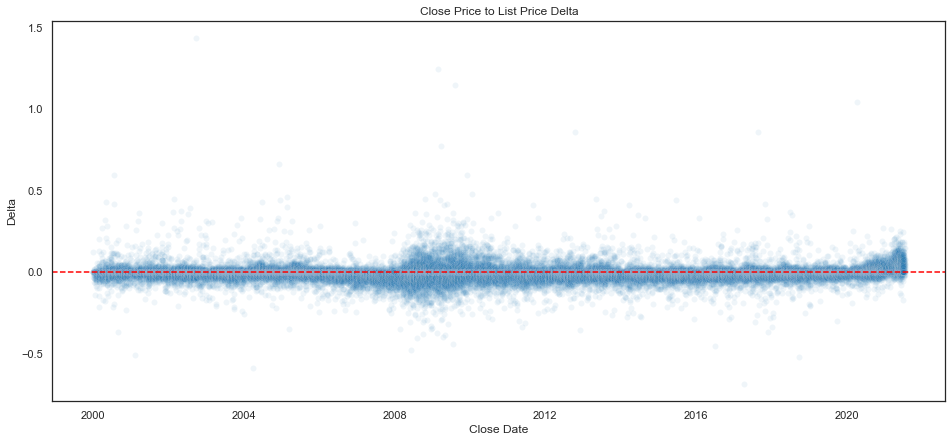

In [163]:
fig20, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(data=df.loc[df.close_year > 1999, :],
                x='close_date',
                y='close_list_delta',
                alpha=0.07,
                ax=ax0)
ax0.set_title('Close Price to List Price Delta')
ax0.set_xlabel('Close Date')
ax0.set_ylabel('Delta')

plt.axhline(y=0,
            color='red',
            ls='--')

fig20.savefig('data/exports/plots/close_list_history_scatter.png')

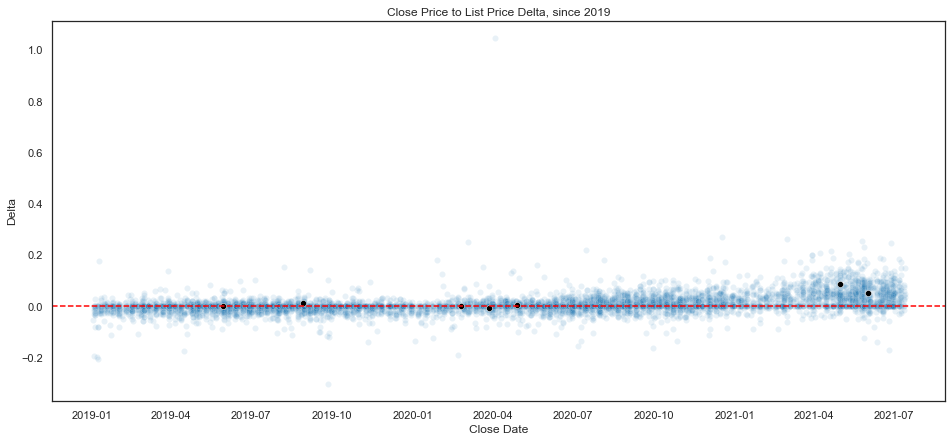

In [164]:
fig21, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(data=df.loc[(df.close_year > 2018), :],
                x='close_date',
                y='close_list_delta',
                alpha=0.1,
                ax=ax0)
ax0.set_title('Close Price to List Price Delta, since 2019')
ax0.set_xlabel('Close Date')
ax0.set_ylabel('Delta')

sns.scatterplot(data=df.loc[(df.close_year > 2018)&
                            (df.agent_sale_dual == 1), :],
                x='close_date',
                y='close_list_delta',
                color='black',
                ax=ax0)

plt.axhline(y=0,
            color='red',
            ls='--')

fig21.savefig('data/exports/plots/close_list_history_2019_scatter.png')

#### Subdivision_Neighborhood

The subdivision_neighborhood feature has 870 different entries. The greatest of which constitutes 4.4% of the entries in the dataset. It is highly likely that there are overlapping classifications where a specific neighborhood for a house is entered, but another house from the same neighborhood is entered with a different entry. As a result, I'll withhold using this as part of my initial modeling efforts. It may be possible to build models for specific neighborhoods, but the column would need to be cleaned to ensure the proper subdivision is entered for a house and not a entry like "Manassas Park", which is a corporate city entity.

In [165]:
subdivision_counts = df.subdivision_neighborhood.value_counts(dropna=False)
subdivision_pcts = df.subdivision_neighborhood.value_counts(dropna=False,
                                                            normalize=True)

pd.concat([subdivision_counts, subdivision_pcts],
          axis=1,
          keys=['counts', '%'])

counts         %
MANASSAS PARK                   2194  0.043526
BRAEMAR                         1950  0.038685
NONE AVAILABLE                  1880  0.037296
PIEDMONT                        1809  0.035888
DOMINION VALLEY COUNTRY CLUB    1632  0.032376
...                              ...       ...
BELLWOOD FARM                      1  0.000020
KETTLE RUN                         1  0.000020
FLEETWOOD ESTATES                  1  0.000020
STONINGTON                         1  0.000020
NaN                                1  0.000020

[870 rows x 2 columns]

#### Finished Square Footage

The finished square footage features are woefully incomplete or have data inputs that are beyond repair. For example, the entire dataset has ~50k observations and of those observations only ~50% have values entered for finished square footage. Then, on top of that, some observations have square footages that are below 500 finished square feet or over 15,000 finished square feet.

In [166]:
df[['above_grade_finished_sqft',
    'below_grade_finished_sqft',
    'total_finished_sqft']].isnull().sum()

above_grade_finished_sqft    21828
below_grade_finished_sqft    29825
total_finished_sqft          21762
dtype: int64

In [167]:
df = df.reset_index(drop=True)

In [168]:
print(df.head(5))

        mls_#                  address zip_code         city  dom close_date  \
0  VAPW289124   10087 Post Oak Terrace    20110     Manassas   12 2000-01-03   
1  VAPW250326       7409 Howell Run Ct    20112     Manassas    1 2000-01-04   
2  VAPW284200      8543 Dover Downs Ct    20155  Gainesville    5 2000-01-06   
3  VAPW289210      10415 Labrador Loop    20112     Manassas    3 2000-01-06   
4  VAPW292248  7544 Belle Grae Dr #1-5    20109     Manassas  456 2000-01-06   

   close_price  beds  bathrooms_full  bathrooms_half  ... list_office_code  \
0       304417   4.0             2.0             1.0  ...            DUNN1   
1       311528   4.0             3.0             1.0  ...            COMP1   
2       219500   3.0             2.0             1.0  ...           CENT70   
3       199950   4.0             2.0             1.0  ...            CBS20   
4        56000   3.0             2.0             0.0  ...            COMP1   

  list_office_broker_of_record_id  agent_sale_dual

### Correlation Heatmap of correlation matrix

A correlation matrix and associated heatmap was produced to get a sense of how well correlated, select numeric features were amongst each other and the target feature, close_price.  Based on the results

- close_price & bathrooms_full: 0.59
- close_price & year_built: 0.56
- close_price & total_garage_spaces: 0.50

showed the highest amount of correlation with the close_price.

Upon review of the correlation matrix heatmap, several combinations of the independent variables showed moderate levels of correlation:

- beds & bathrooms_full: 0.51
- year_built & hoa: 0.68,
- year_built & bathrooms_full: 0.50
- year_built & bathrooms_half: 0.45
- year_built & basement: 0.47
- year_built & total_garage_spaces: 0.55

Upon predictive model development, attention will be paid to prevent issues of multicollinearity from happening.

In [169]:
df_corr = df[['close_price',
              'beds',
              'bathrooms_full',
              'bathrooms_half',
              'basement',
              'fireplaces_total',
              'levels_stories',
              'total_garage_spaces',
              'hoa',
              'year_built',
              'close_month',
              'close_year']].corr()

In [170]:
df_corr

close_price      beds  bathrooms_full  bathrooms_half  \
close_price             1.000000  0.365477        0.592795        0.334926   
beds                    0.365477  1.000000        0.514479        0.233441   
bathrooms_full          0.592795  0.514479        1.000000        0.127613   
bathrooms_half          0.334926  0.233441        0.127613        1.000000   
basement                0.334972  0.309910        0.374064        0.328994   
fireplaces_total        0.410781  0.236903        0.361696        0.214846   
levels_stories          0.405609  0.364350        0.393099        0.531243   
total_garage_spaces     0.503344  0.244908        0.386820        0.369387   
hoa                     0.433636  0.211422        0.378794        0.373502   
year_built              0.569652  0.254427        0.497568        0.454669   
close_month             0.005425 -0.006943       -0.002669       -0.009501   
close_year              0.325518  0.107257        0.251206        0.071205   

                     basement  fireplaces_total  levels_stories  \
close_price          0.334972          0.410781        0.405609   
beds                 0.309910          0.236903        0.364350   
bathrooms_full       0.374064          0.361696        0.393099   
bathrooms_half       0.328994          0.214846        0.531243   
basement             1.000000          0.277542        0.677029   
fireplaces_total     0.277542          1.000000        0.248507   
levels_stories       0.677029          0.248507        1.000000   
total_garage_spaces  0.308015          0.310884        0.406410   
hoa                  0.322915          0.153600        0.455027   
year_built           0.465438          0.229350        0.595715   
close_month          0.002946         -0.004203       -0.004390   
close_year           0.064071          0.092035        0.067210   

                     total_garage_spaces       hoa  year_built  close_month  \
close_price                     0.503344  0.433636    0.569652     0.005425   
beds                            0.244908  0.211422    0.254427    -0.006943   
bathrooms_full                  0.386820  0.378794    0.497568    -0.002669   
bathrooms_half                  0.369387  0.373502    0.454669    -0.009501   
basement                        0.308015  0.322915    0.465438     0.002946   
fireplaces_total                0.310884  0.153600    0.229350    -0.004203   
levels_stories                  0.406410  0.455027    0.595715    -0.004390   
total_garage_spaces             1.000000  0.395793    0.549785    -0.007322   
hoa                             0.395793  1.000000    0.681437    -0.006819   
year_built                      0.549785  0.681437    1.000000     0.000306   
close_month                    -0.007322 -0.006819    0.000306     1.000000   
close_year                      0.106157  0.225479    0.159275    -0.053391   

                     close_year  
close_price            0.325518  
beds                   0.107257  
bathrooms_full         0.251206  
bathrooms_half         0.071205  
basement               0.064071  
fireplaces_total       0.092035  
levels_stories         0.067210  
total_garage_spaces    0.106157  
hoa                    0.225479  
year_built             0.159275  
close_month           -0.053391  
close_year             1.000000

<AxesSubplot:>

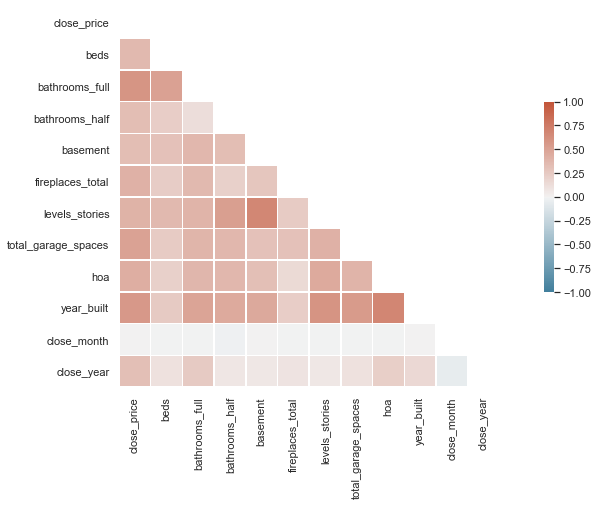

In [171]:
mask = np.triu(np.ones_like(df_corr, dtype=bool))

fig22, ax0 = plt.subplots(1, 1, figsize=(16, 7))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            center=0,
            vmin=-1,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5})

In [172]:
df.columns

Index(['mls_#', 'address', 'zip_code', 'city', 'dom', 'close_date',
       'close_price', 'beds', 'bathrooms_full', 'bathrooms_half',
       'subdivision_neighborhood', 'structure_type', 'basement',
       'fireplaces_total', 'levels_stories', 'total_garage_spaces',
       'above_grade_finished_sqft', 'below_grade_finished_sqft',
       'condo_coop_assoc', 'fireplace', 'garage', 'hoa', 'list_price',
       'lot_size_sqft', 'school_district', 'total_finished_sqft', 'year_built',
       'list_agent_full_name', 'list_office_name', 'list_office_code',
       'list_office_broker_of_record_id', 'agent_sale_dual', 'latitude',
       'longitude', 'close_month', 'close_year', 'close_week_num',
       'full_address', 'close_list_delta'],
      dtype='object')

In [173]:
bound_box = ((df.longitude.min(), df.longitude.max(),
              df.latitude.min(), df.latitude.max()))
bound_box

(-78.00652600000001, -77.22106500000001, 38.474116699999996, 38.9352267)

Based on the plot of housing geolocations, some houses fall outside of the area of interest. What likely happened is that the real estate agent that entered the housing data entered the wrong zip code.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

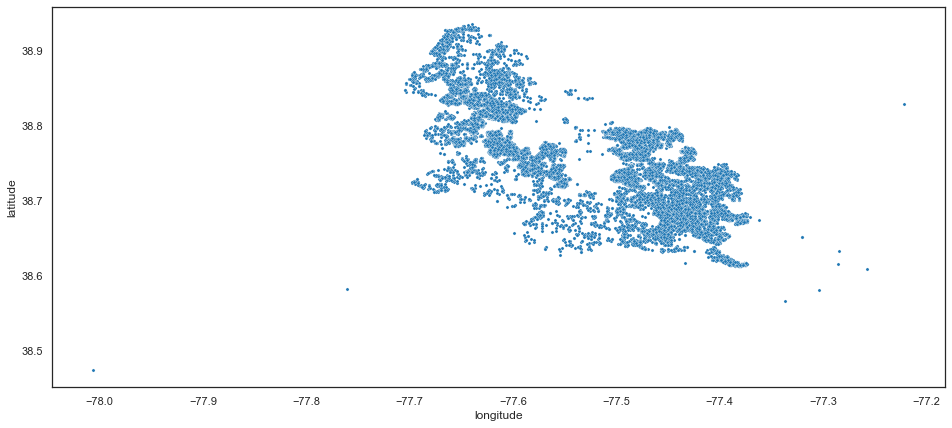

In [174]:
fig23, ax0 = plt.subplots(1, 1, figsize=(16, 7 ))

sns.scatterplot(data=df,
                x='longitude',
                y='latitude',
                # hue='hoa',
                # style='hoa',
                alpha=1,
                s=10,
                ax=ax0)

Review the outlying geo-locations and upon validation that they are not truly located within the geographic area of interest, remove them from the dataset.

In [175]:
df.loc[(df.longitude <= -77.74) |
       (df.longitude >= -77.35), :]

mls_#                         address zip_code        city  dom  \
4282   VAPW265872                   0 Dominion Dr    20155   Haymarket  510   
7143   VAFQ116806               705 Monument Lane    20109    Culpeper    0   
8347   VAFQ116790                    10791 Tibert    20110    Bealeton    0   
16223  VAPW128598         15963 Canada Goose Loop    20169   Haymarket    0   
16349  VAPW130104         13895 Hedgewood Dr #125    20169   Haymarket    0   
16350  VAPW130102              13895 Hedgewood Dr    20169   Haymarket    0   
17035  VAPW135346                 15521 Exmore Ct    20169   Haymarket    0   
17193  VAPW136608            14507 Crossfield Way    20169   Haymarket    0   
18689  VAPW108298               13609 American Dr    20136     Bristow  106   
37813  1000365723  17025 Gibson Mill Rd Dr #17025    20181  Nokesville    1   

      close_date  close_price  beds  bathrooms_full  bathrooms_half  ...  \
4282  2002-05-23       325025   4.0             2.0             0.0  ...   
7143  2003-07-29       206520   4.0             2.0             0.0  ...   
8347  2003-12-23       379240   4.0             2.0             1.0  ...   
16223 2006-06-01       476250   1.0             1.0             1.0  ...   
16349 2006-06-26       520000   1.0             1.0             0.0  ...   
16350 2006-06-26       520000   1.0             1.0             0.0  ...   
17035 2006-10-18       465800   1.0             1.0             0.0  ...   
17193 2006-11-17       464500   1.0             1.0             0.0  ...   
18689 2007-09-07       495000   4.0             4.0             1.0  ...   
37813 2016-03-31       290000   3.0             2.0             0.0  ...   

      list_office_code list_office_broker_of_record_id  agent_sale_dual  \
4282             COMP1                             NaN              0.0   
7143             COMP1                             NaN              0.0   
8347             COMP1                             NaN              0.0   
16223            COMP1                             NaN              0.0   
16349            COMP1                             NaN              0.0   
16350            COMP1                             NaN              0.0   
17035            COMP1                             NaN              0.0   
17193            COMP1                             NaN              0.0   
18689            PAPR1                         12727.0              0.0   
37813            SAMP1                       3015801.0              0.0   

        latitude  longitude  close_month close_year close_week_num  \
4282   38.566591 -77.336276          5.0     2002.0             20   
7143   38.474117 -78.006526          7.0     2003.0             30   
8347   38.581989 -77.760765         12.0     2003.0             51   
16223  38.608904 -77.257695          6.0     2006.0             22   
16349  38.651530 -77.319953          6.0     2006.0             26   
16350  38.651530 -77.319953          6.0     2006.0             26   
17035  38.614892 -77.285824         10.0     2006.0             42   
17193  38.632756 -77.284316         11.0     2006.0             46   
18689  38.828100 -77.221065          9.0     2007.0             36   
37813  38.581183 -77.303594          3.0     2016.0             13   

                                            full_address close_list_delta  
4282                0 Dominion Dr, Haymarket, VA 20155.0          0.00000  
7143             705 Monument Lane, Culpeper, VA 20109.0          0.00000  
8347                  10791 Tibert, Bealeton, VA 20110.0          0.00000  
16223     15963 Canada Goose Loop, Haymarket, VA 20169.0          0.00000  
16349     13895 Hedgewood Dr #125, Haymarket, VA 20169.0          0.00000  
16350          13895 Hedgewood Dr, Haymarket, VA 20169.0          0.00000  
17035             15521 Exmore Ct, Haymarket, VA 20169.0          0.00000  
17193        14507 Crossfield Way, Haymarket, VA 20169.0          0.00000  
18689             13609 

Geocodio seems to have mis-geocoded the following mls_#. Below are the correct latitudes and longitudes based on a manual Google Maps lookup.

- Update
- VAPW108298: latitude: 38.7656596, longitude: -77.599344
- VAPW525250: latitude: 38.7421429, longitude: -77.5542407
-
-
- Remove
- VAFQ116806: latitude: 38.4741052, longitude: -78.0064175
- VAFQ116790: latitude: 38.5819654, longitude: -77.7606881
- VAPW128598: latitude: 38.6089024, longitude: -77.2575775
- VAPW136608: latitude: 38.6327562, longitude: -77.2842027
- VAPW135346: latitude: 38.6148872, longitude: -77.2857117
- 1000365723: latitude: 38.476119, longitude: -78.0627721
- VAPW130104: latitude: 38.6512113, longitude: -77.3197616
- VAPW130102: latitude: 38.6512113, longitude: -77.3197616
- VAPW265872: latitude: 38.839553, longitude: -77.6513499

In [176]:
mls_remove = ['VAFQ116806',
              'VAFQ116790',
              'VAPW128598',
              'VAPW136608',
              'VAPW135346',
              '1000365723',
              'VAPW130104',
              'VAPW130102',
              'VAPW265872']

In [177]:
df.loc[~df['mls_#'].isin(mls_remove), :]

mls_#                  address zip_code         city  dom  \
0      VAPW289124   10087 Post Oak Terrace    20110     Manassas   12   
1      VAPW250326       7409 Howell Run Ct    20112     Manassas    1   
2      VAPW284200      8543 Dover Downs Ct    20155  Gainesville    5   
3      VAPW289210      10415 Labrador Loop    20112     Manassas    3   
4      VAPW292248  7544 Belle Grae Dr #1-5    20109     Manassas  456   
...           ...                      ...      ...          ...  ...   
50402  VAPW522440      15705 Rothschild Ct    20169    Haymarket    6   
50403  VAPW525310   15160 Jupiter Hills Ln    20169    Haymarket    3   
50404  VAPW521352   13130 Carriage Ford Rd    20181   Nokesville    5   
50405  VAPW524372       10209 Inchberry Ct    20136      Bristow    6   
50406  VAPW514438      9128 Acadia Park Dr    20136      Bristow    4   

      close_date  close_price  beds  bathrooms_full  bathrooms_half  ...  \
0     2000-01-03       304417   4.0             2.0             1.0  ...   
1     2000-01-04       311528   4.0             3.0             1.0  ...   
2     2000-01-06       219500   3.0             2.0             1.0  ...   
3     2000-01-06       199950   4.0             2.0             1.0  ...   
4     2000-01-06        56000   3.0             2.0             0.0  ...   
...          ...          ...   ...             ...             ...  ...   
50402 2021-06-21       870000   5.0             3.0             1.0  ...   
50403 2021-07-09       700000   4.0             3.0             1.0  ...   
50404 2021-06-28       895000   4.0             4.0             1.0  ...   
50405 2021-07-07       685000   4.0             2.0             1.0  ...   
50406 2021-06-30       820000   4.0             4.0             1.0  ...   

      list_office_code list_office_broker_of_record_id  agent_sale_dual  \
0                DUNN1                             NaN              0.0   
1                COMP1                             NaN              0.0   
2               CENT70                             NaN              0.0   
3                CBS20                             NaN              0.0   
4                COMP1                             NaN              0.0   
...                ...                             ...              ...   
50402            WEI49                         51175.0              0.0   
50403            WEI58                         51175.0              0.0   
50404            WEI58                         51175.0              0.0   
50405            WEI69                         51175.0              0.0   
50406            WEI69                         51175.0              0.0   

        latitude  longitude  close_month close_year close_week_num  \
0      38.729589 -77.502239          1.0     2000.0              1   
1      38.672901 -77.428282          1.0     2000.0              1   
2      38.771562 -77.602819          1.0     2000.0              1   
3      38.728245 -77.480414          1.0     2000.0              1   
4      38.792258 -77.511938          1.0     2000.0              1   
...          ...        ...          ...        ...            ...   
50402  38.833891 -77.654555          6.0     2021.0             25   
50403  38.831524 -77.644221          7.0     2021.0             27   
50404  38.672182 -77.587255          6.0     2021.0             26   
50405  38.734527 -77.585500          7.0     2021.0             27   
50406  38.757925 -77.571293          6.0     2021.0             26   

                                         full_address close_list_delta  
0        10087 Post Oak Terrace, Manassas, VA 20110.0         0.123310  
1            7409 Howell Run Ct, Manassas, VA 20112.0         0.000000  
2        8543 Dover Downs Ct, Gainesville, VA 20155.0         0.000000  
3           10415 Labrador Loop, Manassas, VA 20112.0         0.000000  
4       7544 Belle Grae Dr #1-5, Manassas, VA 20109.0         0.000000  
...                                       

In [178]:
df = df.loc[~df['mls_#'].isin(mls_remove), :]

In [179]:
print(df.loc[df['mls_#'] == 'VAPW108298',:])

            mls_#            address zip_code     city  dom close_date  \
18689  VAPW108298  13609 American Dr    20136  Bristow  106 2007-09-07   

       close_price  beds  bathrooms_full  bathrooms_half  ...  \
18689       495000   4.0             4.0             1.0  ...   

      list_office_code list_office_broker_of_record_id  agent_sale_dual  \
18689            PAPR1                         12727.0              0.0   

       latitude  longitude  close_month close_year close_week_num  \
18689   38.8281 -77.221065          9.0     2007.0             36   

                                 full_address close_list_delta  
18689  13609 American Dr, Bristow, VA 20136.0         -0.00998  

[1 rows x 39 columns]


In [180]:
df.loc[df['mls_#'] == 'VAPW108298', 'latitude'] = 38.7656596
df.loc[df['mls_#'] == 'VAPW108298', 'longitude'] = -77.599344

In [181]:
print(df.loc[(df['mls_#'] == 'VAPW108298'), :])

            mls_#            address zip_code     city  dom close_date  \
18689  VAPW108298  13609 American Dr    20136  Bristow  106 2007-09-07   

       close_price  beds  bathrooms_full  bathrooms_half  ...  \
18689       495000   4.0             4.0             1.0  ...   

      list_office_code list_office_broker_of_record_id  agent_sale_dual  \
18689            PAPR1                         12727.0              0.0   

       latitude  longitude  close_month close_year close_week_num  \
18689  38.76566 -77.599344          9.0     2007.0             36   

                                 full_address close_list_delta  
18689  13609 American Dr, Bristow, VA 20136.0         -0.00998  

[1 rows x 39 columns]


Calculate coordinates to create a bound box for establishing dimensions for a map extract

In [182]:
bound_box_2 = (df.longitude.min(), df.longitude.max(), df.latitude.min(), df.latitude.max())
bound_box_2

(-77.70463600000001, -77.361361, 38.6130077, 38.9352267)

Scatterplot using latitude and longitude coordinates as the x and y coordinates to show the distribution of houses sold between 2000 and mid-2021.

[Text(0.5, 1.0, 'Distribution of Detached Housing Sales\n1/1/2000 - 7/13/2021'),
 Text(0.5, 0, 'Longitude'),
 Text(0, 0.5, 'Latitude')]

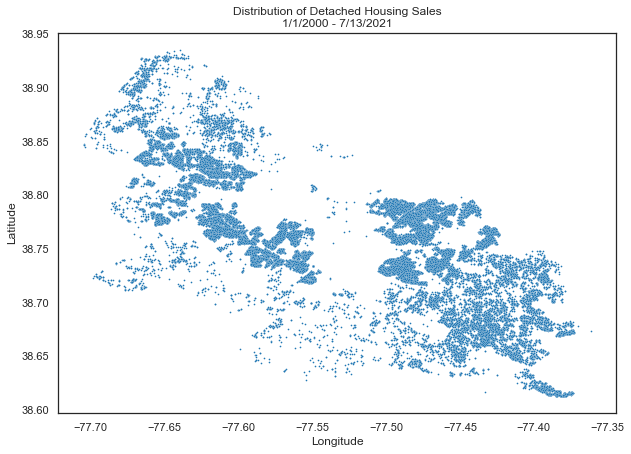

In [183]:
fig24, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.scatterplot(data=df,
                x='longitude',
                y='latitude',
                alpha=1,
                s=3,
                # hue='zip_code',
                # style='zip_code',
                ax=ax0)

ax0.set(title='Distribution of Detached Housing Sales\n1/1/2000 - 7/13/2021',
        xlabel='Longitude',
        ylabel='Latitude')

[Text(0.5, 1.0, 'Distribution of Detached Housing Sales by Zip Code\n1/1/2000 - 7/13/2021'),
 Text(0.5, 0, 'Longitude'),
 Text(0, 0.5, 'Latitude')]

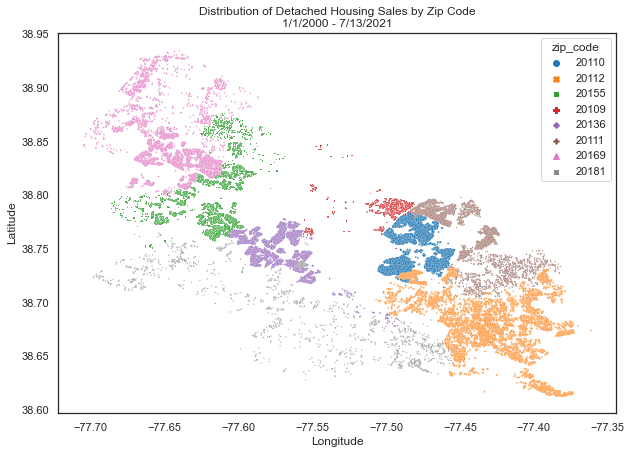

In [184]:
fig, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.scatterplot(data=df,
                x='longitude',
                y='latitude',
                alpha=1,
                s=3,
                hue='zip_code',
                style='zip_code',
                ax=ax0)

ax0.set(title='Distribution of Detached Housing Sales by Zip Code\n1/1/2000 - 7/13/2021',
        xlabel='Longitude',
        ylabel='Latitude')

[Text(0.5, 1.0, 'Distribution of Detached Housing Sales by HOA\n1/1/2000 - 7/13/2021'),
 Text(0.5, 0, 'Longitude'),
 Text(0, 0.5, 'Latitude')]

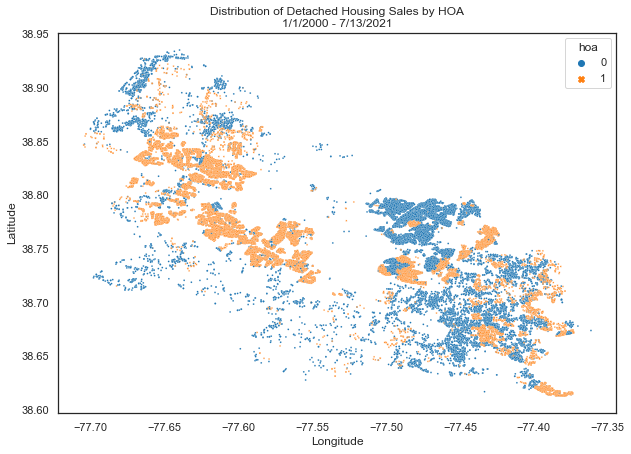

In [185]:
fig, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.scatterplot(data=df,
                x='longitude',
                y='latitude',
                alpha=1,
                s=3,
                hue='hoa',
                style='hoa',
                ax=ax0)

ax0.set(title='Distribution of Detached Housing Sales by HOA\n1/1/2000 - 7/13/2021',
        xlabel='Longitude',
        ylabel='Latitude')

[Text(0.5, 1.0, 'Distribution of Detached Housing Sales by Close Price\n1/1/2000 - 7/13/2021'),
 Text(0.5, 0, 'Longitude'),
 Text(0, 0.5, 'Latitude')]

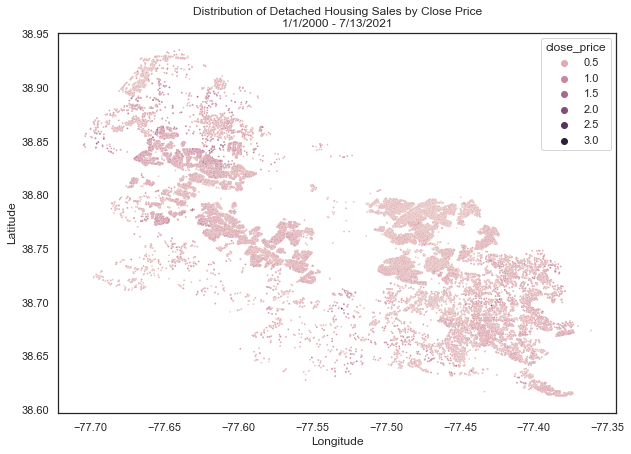

In [186]:
fig, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.scatterplot(data=df,
                x='longitude',
                y='latitude',
                alpha=1,
                s=3,
                hue='close_price',
                # style='hoa',
                ax=ax0)

ax0.set(title='Distribution of Detached Housing Sales by Close Price\n1/1/2000 - 7/13/2021',
        xlabel='Longitude',
        ylabel='Latitude')

[Text(0.5, 1.0, 'Distribution of Detached Housing Sales by Close to List Price Delta\n1/1/2000 - 7/13/2021'),
 Text(0.5, 0, 'Longitude'),
 Text(0, 0.5, 'Latitude')]

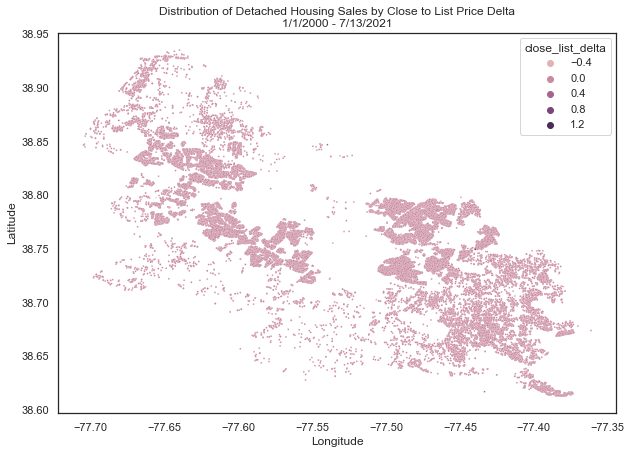

In [187]:
fig, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.scatterplot(data=df,
                x='longitude',
                y='latitude',
                alpha=1,
                s=3,
                hue='close_list_delta',
                # style='hoa',
                ax=ax0)

ax0.set(title='Distribution of Detached Housing Sales by Close to List Price Delta\n1/1/2000 - 7/13/2021',
        xlabel='Longitude',
        ylabel='Latitude')


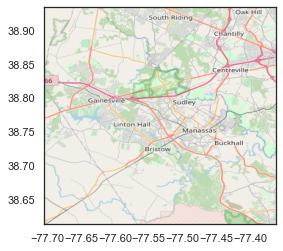

In [188]:
pwc_map_img = mpimg.imread('data/map.png')
pwc_map_plot = plt.imshow(pwc_map_img, extent=bound_box_2)

[]

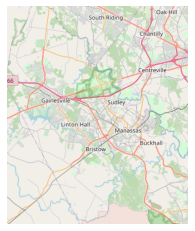

In [189]:
fig25, ax0 = plt.subplots(1, 1)
ax0.imshow(pwc_map_img)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.set_xticks([])
ax0.set_yticks([])

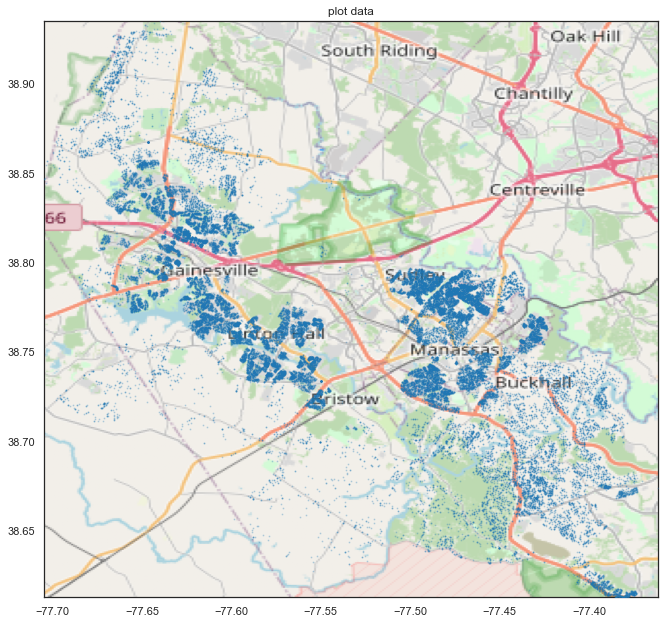

In [190]:
fig, ax = plt.subplots(figsize=(11,13))

ax.scatter(df.longitude, df.latitude, zorder=10, alpha=.2, s=1)

ax.set_title('plot data')
ax.set_xlim(bound_box_2[0], bound_box_2[1])
ax.set_ylim(bound_box_2[2], bound_box_2[3])

ax.imshow(pwc_map_img, zorder=1, extent=bound_box_2, aspect='equal')

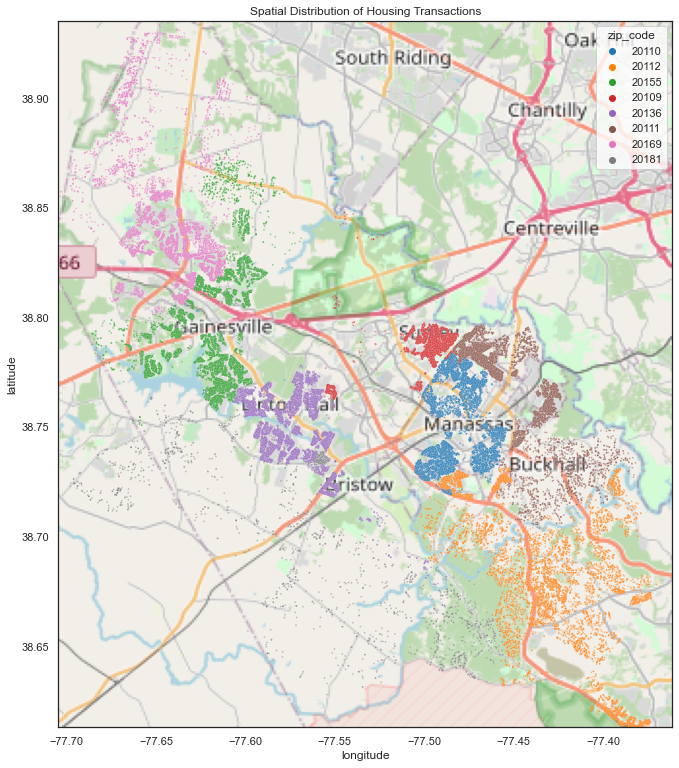

In [191]:
fig26, ax0 = plt.subplots(1, 1, figsize=(11, 13))

sns.scatterplot(data=df,
                x='longitude',
                y='latitude',
                alpha=0.5,
                s=3,
                hue='zip_code',
                ax=ax0)

ax0.set_title('Spatial Distribution of Housing Transactions')
ax0.set_xlim(bound_box_2[0], bound_box_2[1])
ax0.set_ylim(bound_box_2[2], bound_box_2[3])

ax0.imshow(pwc_map_img,
           extent=bound_box_2,
           aspect='auto')

In [192]:
df.head(2)

mls_#                 address zip_code      city  dom close_date  \
0  VAPW289124  10087 Post Oak Terrace    20110  Manassas   12 2000-01-03   
1  VAPW250326      7409 Howell Run Ct    20112  Manassas    1 2000-01-04   

   close_price  beds  bathrooms_full  bathrooms_half  ... list_office_code  \
0       304417   4.0             2.0             1.0  ...            DUNN1   
1       311528   4.0             3.0             1.0  ...            COMP1   

  list_office_broker_of_record_id  agent_sale_dual   latitude  longitude  \
0                             NaN              0.0  38.729589 -77.502239   
1                             NaN              0.0  38.672901 -77.428282   

   close_month close_year close_week_num  \
0          1.0     2000.0              1   
1          1.0     2000.0              1   

                                   full_address close_list_delta  
0  10087 Post Oak Terrace, Manassas, VA 20110.0          0.12331  
1      7409 Howell Run Ct, Manassas, VA 20112.0          0.00000  

[2 rows x 39 columns]

### Create X and y datasets

The X and y datasets will comprise the numeric features used above in the correlation matrix investigation plus the zip_code, which is not a numeric feature.

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50398 entries, 0 to 50406
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   mls_#                            50398 non-null  object        
 1   address                          50398 non-null  object        
 2   zip_code                         50398 non-null  object        
 3   city                             50398 non-null  object        
 4   dom                              50398 non-null  int64         
 5   close_date                       50398 non-null  datetime64[ns]
 6   close_price                      50398 non-null  int64         
 7   beds                             50398 non-null  float64       
 8   bathrooms_full                   50398 non-null  float64       
 9   bathrooms_half                   50398 non-null  float64       
 10  subdivision_neighborhood         50397 non-null  object   

In [194]:
df.iloc[:, np.r_[6, 7, 8, 9, 12, 13, 14, 15, 21, 26, 34, 35, 36]]

close_price  beds  bathrooms_full  bathrooms_half  basement  \
0           304417   4.0             2.0             1.0         1   
1           311528   4.0             3.0             1.0         1   
2           219500   3.0             2.0             1.0         1   
3           199950   4.0             2.0             1.0         1   
4            56000   3.0             2.0             0.0         0   
...            ...   ...             ...             ...       ...   
50402       870000   5.0             3.0             1.0         1   
50403       700000   4.0             3.0             1.0         1   
50404       895000   4.0             4.0             1.0         1   
50405       685000   4.0             2.0             1.0         1   
50406       820000   4.0             4.0             1.0         1   

       fireplaces_total  levels_stories  total_garage_spaces  hoa  year_built  \
0                   1.0             3.0                  2.0    0      1999.0   
1                   1.0             3.0                  2.0    0      1999.0   
2                   1.0             3.0                  2.0    0      1997.0   
3                   1.0             3.0                  2.0    0      1991.0   
4                   0.0             2.0                  0.0    0      1986.0   
...                 ...             ...                  ...  ...         ...   
50402               1.0             3.0                  2.0    1      2006.0   
50403               1.0             3.0                  2.0    1      2003.0   
50404               1.0             3.0                  7.0    1      1991.0   
50405               1.0             3.0                  2.0    1      2005.0   
50406               1.0             3.0                  3.0    1      2003.0   

       close_month  close_year  close_week_num  
0              1.0      2000.0               1  
1              1.0      2000.0               1  
2              1.0      2000.0               1  
3              1.0      2000.0               1  
4              1.0      2000.0               1  
...            ...         ...             ...  
50402          6.0      2021.0              25  
50403          7.0      2021.0              27  
50404          6.0      2021.0              26  
50405          7.0      2021.0              27  
50406          6.0      2021.0              26  

[50398 rows x 13 columns]

In [195]:
df = df.iloc[:, np.r_[6, 7, 8, 9, 12, 13, 14, 15, 21, 26, 34, 35, 36]]

In [196]:
df.to_csv('data/exports/modeling_df.csv')

In [197]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50398 entries, 0 to 50406
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   close_price          50398 non-null  int64  
 1   beds                 50398 non-null  float64
 2   bathrooms_full       50398 non-null  float64
 3   bathrooms_half       50398 non-null  float64
 4   basement             50398 non-null  int64  
 5   fireplaces_total     50398 non-null  float64
 6   levels_stories       50398 non-null  float64
 7   total_garage_spaces  50398 non-null  float64
 8   hoa                  50398 non-null  int64  
 9   year_built           50398 non-null  float64
 10  close_month          50398 non-null  float64
 11  close_year           50398 non-null  float64
 12  close_week_num       50398 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 5.4 MB
None


close_price          beds  bathrooms_full  bathrooms_half  \
count  5.039800e+04  50398.000000    50398.000000    50398.000000   
mean   4.327279e+05      3.981348        2.660582        0.728541   
std    1.736945e+05      0.826622        0.857346        0.508732   
min    1.650000e+04      0.000000        0.000000        0.000000   
25%    3.170000e+05      4.000000        2.000000        0.000000   
50%    4.186365e+05      4.000000        3.000000        1.000000   
75%    5.250000e+05      4.000000        3.000000        1.000000   
max    3.000000e+06     50.000000        7.000000        4.000000   

           basement  fireplaces_total  levels_stories  total_garage_spaces  \
count  50398.000000      50398.000000    50398.000000         50398.000000   
mean       0.843605          0.975416        2.636652             1.565161   
std        0.363233          0.580769        0.592336             0.971053   
min        0.000000          0.000000        1.000000             0.000000   
25%        1.000000          1.000000        2.000000             1.000000   
50%        1.000000          1.000000        3.000000             2.000000   
75%        1.000000          1.000000        3.000000             2.000000   
max        1.000000          9.000000        4.000000            20.000000   

                hoa    year_built   close_month    close_year  close_week_num  
count  50398.000000  50398.000000  50398.000000  50398.000000    50398.000000  
mean       0.539962   1991.129331      6.627307   2010.194274       27.135144  
std        0.498405     16.345757      3.175379      6.144000       13.823642  
min        0.000000   1950.000000      1.000000   2000.000000        0.000000  
25%        0.000000   1979.000000      4.000000   2005.000000       17.000000  
50%        1.000000   1998.000000      7.000000   2010.000000       26.000000  
75%        1.000000   2003.000000      9.000000   2016.000000       38.000000  
max        1.000000   2021.000000     12.000000   2021.000000       53.000000

In [147]:
df.iloc[:, np.r_[1:13]]

beds  bathrooms_full  bathrooms_half  basement  fireplaces_total  \
0         4               2             1.0         1               1.0   
1         4               3             1.0         1               1.0   
2         3               2             1.0         1               1.0   
3         4               2             1.0         1               1.0   
4         3               2             0.0         0               0.0   
...     ...             ...             ...       ...               ...   
50404     5               3             1.0         1               1.0   
50405     4               3             1.0         1               1.0   
50406     4               4             1.0         1               1.0   
50407     4               2             1.0         1               1.0   
50408     4               4             1.0         1               1.0   

      levels_stories  total_garage_spaces  hoa  year_built  close_month  \
0                  3                  2.0    0      1999.0            1   
1                  3                  2.0    0      1999.0            1   
2                  3                  2.0    0      1997.0            1   
3                  3                  2.0    0      1991.0            1   
4                  2                  0.0    0      1986.0            1   
...              ...                  ...  ...         ...          ...   
50404              3                  2.0    1      2006.0            6   
50405              3                  2.0    1      2003.0            7   
50406              3                  7.0    1      1991.0            6   
50407              3                  2.0    1      2005.0            7   
50408              3                  3.0    1      2003.0            6   

       close_year close_week_num  
0            2000             01  
1            2000             01  
2            2000             01  
3            2000             01  
4            2000             01  
...           ...            ...  
50404        2021             25  
50405        2021             27  
50406        2021             26  
50407        2021             27  
50408        2021             26  

[50409 rows x 12 columns]

In [148]:
X = df.iloc[:, np.r_[1:13]]
y = df['close_price']

In [149]:
X_features = list(X.columns)
X_features

['beds',
 'bathrooms_full',
 'bathrooms_half',
 'basement',
 'fireplaces_total',
 'levels_stories',
 'total_garage_spaces',
 'hoa',
 'year_built',
 'close_month',
 'close_year',
 'close_week_num']

### Split data into training and test sets

In [150]:
random_seed = 0
train_pct = 0.7
test_pct = 0.3

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_pct,
                                                    train_size=train_pct,
                                                    random_state=random_seed)

In [152]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(35286, 12)
(35286,)
(15123, 12)
(15123,)


https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1

## Unsupervised Learning

## Supervised Learning

#### Linear Regression

In [154]:
X_train_sm = sm.add_constant(X_train)

In [155]:
X_train_sm.head()

const  beds  bathrooms_full  bathrooms_half  basement  \
2968     1.0     5               3             1.0         1   
10675    1.0     4               3             1.0         1   
37064    1.0     3               2             1.0         1   
15189    1.0     4               2             1.0         1   
11510    1.0     4               1             0.0         0   

       fireplaces_total levels_stories  total_garage_spaces  hoa  year_built  \
2968                2.0              3                  2.0    0      1971.0   
10675               0.0              3                  1.0    1      2000.0   
37064               1.0              2                  2.0    0      1978.0   
15189               1.0              3                  2.0    1      2000.0   
11510               0.0              2                  0.0    0      1957.0   

       close_month  close_year close_week_num  
2968             9        2001             38  
10675            9        2004             37  
37064           11        2015             44  
15189           12        2005             51  
11510           12        2004             49

In [157]:
sm_results = sm.OLS(y_train, X_train_sm.astype(float)).fit()

In [158]:
sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            close_price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     3531.
Date:                Thu, 29 Jul 2021   Prob (F-statistic):               0.00
Time:                        20:14:52   Log-Likelihood:            -4.6188e+05
No. Observations:               35286   AIC:                         9.238e+05
Df Residuals:                   35273   BIC:                         9.239e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -1.5e+07   2.53e+05    -59.370      0.000   -1.55e+07   -1.45e+07
beds                 1.285e+04    926.660     13.872      0.000     1.1e+04    1.47e+04
bathrooms_full       5.654e+04   1033.789     54.693      0.000    5.45e+04    5.86e+04
bathrooms_half       2.932e+04   1563.005     18.762      0.000    2.63e+04    3.24e+04
basement            -1.067e+04   2399.450     -4.449      0.000   -1.54e+04   -5971.658
fireplaces_total     4.846e+04   1203.678     40.264      0.000    4.61e+04    5.08e+04
levels_stories      -5778.1756   1718.950     -3.361      0.001   -9147.371   -2408.980
total_garage_spaces  2.877e+04    792.905     36.283      0.000    2.72e+04    3.03e+04
hoa                  2563.9715   1737.585      1.476      0.140    -841.750    5969.693
year_built           2538.0133     64.210     39.527      0.000    2412.160    2663.866
close_month         -1.084e+04   2052.624     -5.281      0.000   -1.49e+04   -6816.668
close_year           5016.4554    107.652     46.599      0.000    4805.454    5227.456
close_week_num       2764.5576    471.895      5.858      0.000    1839.629    3689.486
==============================================================================
Omnibus:                    17605.684   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           447956.890
Skew:                           1.865   Prob(JB):                         0.00
Kurtosis:                      20.052   Cond. No.                     1.15e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [159]:
sm_results_log = sm.OLS(np.log(y_train), X_train_sm.astype(float)).fit()

In [160]:
sm_results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            close_price   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     4498.
Date:                Thu, 29 Jul 2021   Prob (F-statistic):               0.00
Time:                        20:18:59   Log-Likelihood:                -3166.0
No. Observations:               35286   AIC:                             6358.
Df Residuals:                   35273   BIC:                             6468.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -32.2261      0.571    -56.427      0.000     -33.345     -31.107
beds                    0.0349      0.002     16.656      0.000       0.031       0.039
bathrooms_full          0.0951      0.002     40.687      0.000       0.090       0.100
bathrooms_half          0.0485      0.004     13.726      0.000       0.042       0.055
basement                0.0221      0.005      4.073      0.000       0.011       0.033
fireplaces_total        0.1227      0.003     45.116      0.000       0.117       0.128
levels_stories          0.0023      0.004      0.594      0.552      -0.005       0.010
total_garage_spaces     0.0685      0.002     38.226      0.000       0.065       0.072
hoa                     0.0141      0.004      3.590      0.000       0.006       0.022
year_built              0.0081      0.000     56.154      0.000       0.008       0.008
close_month            -0.0311      0.005     -6.704      0.000      -0.040      -0.022
close_year              0.0140      0.000     57.649      0.000       0.014       0.015
close_week_num          0.0079      0.001      7.426      0.000       0.006       0.010
==============================================================================
Omnibus:                      997.517   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2565.714
Skew:                           0.037   Prob(JB):                         0.00
Kurtosis:                       4.319   Cond. No.                     1.15e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

(1146663.8034733434, 1146663.8034733434)

## Pipeline Objects


#### Numerical and Categorical Column Lists

In [ ]:
num_columns = make_column_selector(dtype_include=np.number)
numeric_columns = num_columns(X_train)
print(numeric_columns)

In [ ]:
cat_columns = make_column_selector(dtype_include=[object, 'category'])
categorical_columns = cat_columns(X_train)
print(categorical_columns)

### Preprocessing

#### Numerical Transformers

In [ ]:
numeric_column_transformer = make_pipeline(SimpleImputer(strategy='median'),
                                           StandardScaler())

#### Categorical Transformers

In [ ]:
categorical_column_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                               OneHotEncoder(handle_unknown='ignore'))

#### Create Column Preprocessors

In [ ]:
preprocessor = make_column_transformer((categorical_column_transformer, categorical_columns),
                                       (numeric_column_transformer, numeric_columns),
                                       remainder='passthrough')
preprocessor

### Cross validation object

In [ ]:
rkf_cv = RepeatedKFold(n_splits=5,
                       n_repeats=5,
                       random_state=random_seed)

rkf_gs = RepeatedKFold(n_splits=5,
                       n_repeats=5,
                       random_state=random_seed)

### Specify models

In [ ]:
linreg = LinearRegression()
treereg = DecisionTreeRegressor()
ridgereg = Ridge()
rfreg = RandomForestRegressor()
knnreg = KNeighborsRegressor()

### Linear Regression

#### Linear Regression with no transformations

In [ ]:
linreg_1 = linreg.fit(X_train, y_train)

In [ ]:
linreg_1.score(X_test, y_test)

In [ ]:
print('Linear Regression Model Features and Coefficients - Target and Features Not Transformed')
pd.DataFrame({'Feature': X_train.columns,
              'Coefficients': linreg_1.coef_})

In [ ]:
linreg_1_preds = linreg_1.predict(X_test)

In [ ]:
fig8, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=linreg_1_preds,
                alpha=0.1)

ax0.set_title('Linear Regression Model - Target and Features Not Transformed')
ax0.set_xlabel('Close Prices - Actual')
ax0.set_ylabel('Close Prices - Predicted')

#### Linear Regression with scaled features


In [ ]:
linreg_2_pipe = make_pipeline(preprocessor,
                              linreg)

In [ ]:
linreg_2_best_model = linreg_2_pipe.fit(X_train, y_train)

In [ ]:
linreg_2_pipe.score(X_test, y_test)

In [ ]:
linreg_2_preds = linreg_2_pipe.predict(X_test)

In [ ]:
fig9, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=linreg_2_preds,
                alpha=0.1)

ax0.set_title('Linear Regression Model - Target Not Transformed, Features Transformed (Scaled)')
ax0.set_xlabel('Close Prices - Actual')
ax0.set_ylabel('Close Prices - Predicted')

Retrieving Features

In [ ]:
features_2 = (linreg_2_pipe['columntransformer'].
              transformers_[0][1].
              named_steps['onehotencoder'].
              get_feature_names(categorical_columns))

In [ ]:
features_2

In [ ]:
features_2 = np.concatenate([features_2, numeric_columns])

In [ ]:
coefs_2 = pd.DataFrame(linreg_2_pipe['linearregression'].coef_,
                       columns=['Coefficients'], index=features_2)

In [ ]:
coefs_2

#### Linear Regression with logged target regressor and scaled features

In [ ]:
linreg_3_pipe = make_pipeline(preprocessor,
                             TransformedTargetRegressor(
                                 regressor=linreg,
                                 func=np.log,
                                 inverse_func=np.exp))

In [ ]:
linreg_3_best_model = linreg_3_pipe.fit(X_train, y_train)

In [ ]:
linreg_3_pipe.score(X_test, y_test)

In [ ]:
linreg_3_preds = linreg_3_pipe.predict(X_test)

In [ ]:
fig10, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=linreg_3_preds,
                alpha=0.1)

ax0.set_title('Linear Regression Model - Target Logged, Features Scaled')
ax0.set_xlabel('Close Prices - Actual')
ax0.set_ylabel('Close Prices - Predicted')

Retreiving Features

In [ ]:
features_3 = (linreg_3_pipe.named_steps['columntransformer'].
              transformers_[0][1].
              named_steps['onehotencoder'].
              get_feature_names(categorical_columns))

In [ ]:
features_3 = np.concatenate([features_3, numeric_columns])

In [ ]:
coefs_3 = pd.DataFrame(linreg_3_pipe['transformedtargetregressor'].regressor_.coef_,
                       columns=['Coefficients'], index=features_3)

In [ ]:
coefs_3


### Decision Tree

#### Decision Tree Regression, no transformations

In [ ]:
ridge_reg_pipe = make_pipeline(non_tree_preprocessor,
                               ridge_reg)

In [ ]:
rf_reg_pipe = make_pipeline(tree_preprocessor,
                            rf_reg)


In [ ]:
knn_reg_pipe = make_pipeline(tree_preprocessor,
                             knn_reg)

### Evaluate Pipelines

In [ ]:
lin_reg_pipe_score = cross_val_score(lin_reg_pipe, X_train, y_train, cv=rkf_cv, scoring='neg_mean_squared_error')

In [ ]:
ridge_reg_pipe_score = cross_val_score(ridge_reg_pipe, X_train, y_train, cv=rkf_cv, scoring='neg_mean_squared_error')

In [ ]:
rf_reg_pipe_score = cross_val_score(rf_reg_pipe, X_train, y_train, cv=rkf_cv, scoring='neg_mean_squared_error')

In [ ]:
knn_reg_pipe_score = cross_val_score(knn_reg_pipe, X_train, y_train, cv=rkf_cv, scoring='neg_mean_squared_error')

In [ ]:
print(f'Linear Regression MSE: {lin_reg_pipe_score.mean()}')
print(f'Ridge Regression MSE: {ridge_reg_pipe_score.mean()}')
print(f'Random Forest Regression MSE: {rf_reg_pipe_score.mean()}')
print(f'KNN Regression MSE: {knn_reg_pipe_score.mean()}')

### Fit pipelines with training data

In [ ]:
lin_reg_pipe.fit(X_train, y_train)

In [ ]:
ridge_reg_pipe.fit(X_train, y_train)

In [ ]:
rf_reg_pipe.fit(X_train, y_train)

In [ ]:
knn_reg_pipe.fit(X_train, y_train)

### Use test data on pipeline to predict

In [ ]:
lin_reg_pipe.predict(X_test)

In [ ]:
ridge_reg_pipe.predict(X_test)

In [ ]:
rf_reg_pipe.predict(X_test)

In [ ]:
knn_reg_pipe.predict(X_test)

### Prediction results